# RNAseq analysis of _D. novameixcana_ females after con- and heterospecific mating

## Introduction

The data files used in this analysis were generated within a Snakemake workflow. Breifly, RNAseq reads were generated from _D. novamexicana_ female samples (heads, ovaries, reproductive tracts, and gonadecotmized abdomen + thorax) that were either from mated females or virgin females. In addition, male _D. novamexicana_ RNAseq reads from a previous study were included in the analysis. First, reads were mapped to the virilis genome (dvir1.06) with HISAT and abundance estimates were derived. Second, the transcriptome structure produced by the genome mapping was utilized in making a canonical genome-based transcriptome that was also queried for abundance with eXpress. Finally, mapped and unmapped reads were used to generate a genome-guided transcriptome assembly and a _de novo_ transcriptome assembly, respectively, using Trinity. Transcripts from both Trinity runs were merged and abundance estimates for the samples were obtained using eXpress. 

The genome-based transcriptome and the Trinity transcriptome were both used to generate a Trinotate annotation. The workflow for these analyses is illustrated below (double-click to enlarge), and the link to the GitHub repository is here.

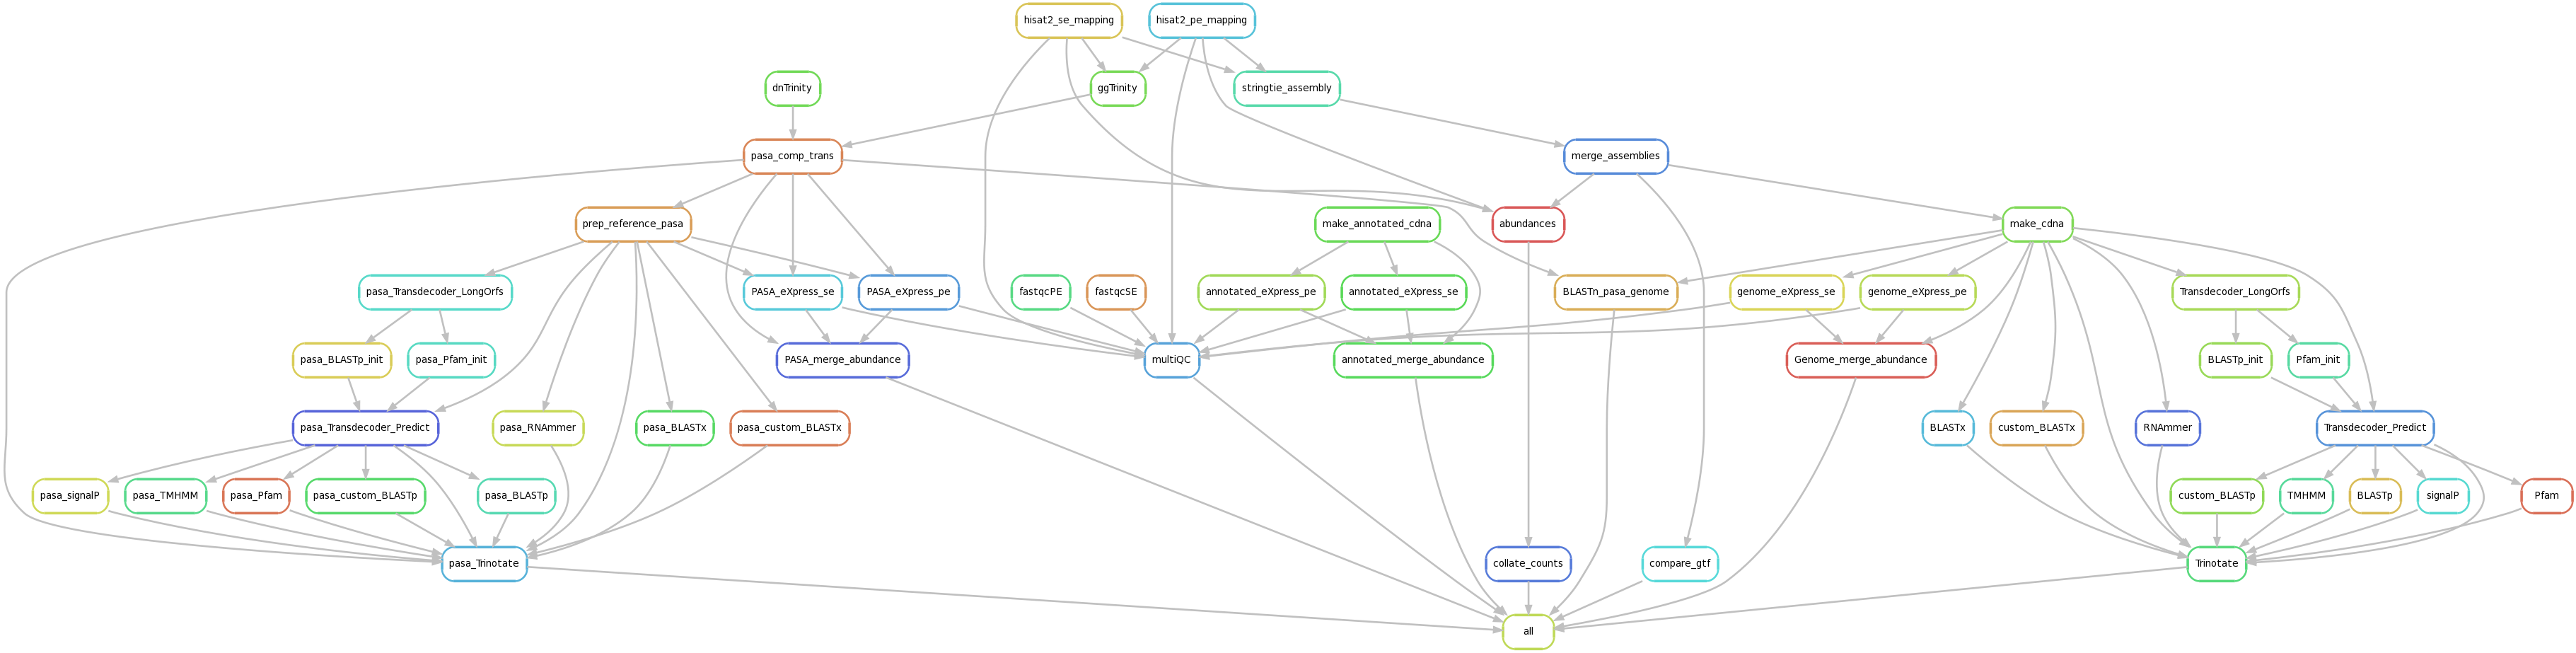

In [1]:
library("IRdisplay")
display_png(file="Misc/workflow.png")

#### Packages and functions:

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. First load the packages:

In [2]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr",
                 "wesanderson", "VennDiagram")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())


... and the custom functions are in a file:

In [3]:
source("Functions2.R")

Suppres excessive VennDiagram's log files:

In [4]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

There are auxiliary files that need to be created from the raw input files. These processes are executed through a shell script, that we can run like so:

In [5]:
# system('./Misc/initial_file_modifications.sh')

#### Annotation files:

A Trinotate report and accompanying Gene Ontology assignments were produced for the genome-based transcriptome and the Trinity transcriptome. Load those here:

In [6]:
trinotate_annotated = read.csv("Trinotate/Annotated/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

trinotate_hisat2 = read.csv("Trinotate/Genome/Trinotate_report_with_description_column.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

trinotate_pasa = read.csv("Trinotate/PASA/Trinotate_report_with_description_column.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

From these reports we also extracted the Gene Ontology (GO) assignments for each gene whenever possible:

In [7]:
GOinfo_annotated = read.table("Trinotate/Annotated/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

GOinfo_hisat2 = read.table("Trinotate/Genome/Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

GOinfo_pasa = read.table("Trinotate/PASA/Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

For the genome data the gene IDs were FlyBase gene names (FBgn..), and we have a file that matches their gene names and coordinates:

In [8]:
dv1.06_features = read.table("Annotations/Genome-based/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we have information on orthology to _D. melanogaster_:

In [9]:
melOrths = read.table(file = "Annotations/Genome-based/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

For normalizaing the hisat2 counts, we'll need the transcript lengths and the gene features files derived from the stringtie gtf. These were produced in the shell using previous scripts, and are loaded here:

In [10]:
gene.features = read.table("StringTie/features.txt", header = T)
trans_lengths = read.csv("StringTie/transcript_lengths.txt", header = T, sep = " ")

For the edgeR DGE object, we can add annotation features for easy querying. First we'll do it for the genome data:

In [11]:
gene_to_ref = unique(subset(gene.features, select=c("gene_id", "ref_gene_id")))

gTrinotate.sub = unique(subset(trinotate_hisat2, select = c("gene_id", "sprot_Top_BLASTX_hit_description")))
gTrinotate.sub = aggregate(sprot_Top_BLASTX_hit_description~gene_id, gTrinotate.sub, toString)

first.annot.merge = merge(gene_to_ref, gTrinotate.sub, by.x = "gene_id", by.y = "gene_id", all = T)

second.annot.merge = merge(melOrthsAll, first.annot.merge, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

third.annot.merge = merge(dv1.06_features, second.annot.merge, by.x = "FBgn_ID", by.y = "FBgn_ID", all = T)

Annots.g = unique(subset(third.annot.merge, select = c('gene_id', 'gene_name', 'mel_GeneSymbol', 'sprot_Top_BLASTX_hit_description')))

... and for the Trinity data:

In [12]:
tTrinotate.sub = unique(subset(trinotate_pasa, select = c("gene_id", "dvir1.06.BLASTX", "sprot_Top_BLASTX_hit_description")))

gene_to_transcript_to_ref = unique(subset(gene.features, select=c("gene_id", "transcript_id", "ref_gene_id")))

all.features = merge(dv1.06_features, gene_to_transcript_to_ref, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

tTrinotate.sub.all = merge(all.features, tTrinotate.sub, by.x = "transcript_id", by.y = "dvir1.06.BLASTX", all = T)

tTrinotate.sub.all = unique(subset(tTrinotate.sub.all, select=c("gene_id.y", "gene_id.x", "gene_name", "FBgn_ID", "chromosome", "min", "max", "sprot_Top_BLASTX_hit_description")))

tTrinotate.sub.all = subset(tTrinotate.sub.all, !is.na(gene_id.y))

tTrinotate.sub.some = unique(subset(tTrinotate.sub.all, select = c("gene_id.y", "gene_id.x", "gene_name", "sprot_Top_BLASTX_hit_description")))

#### Expression files

There are three raw count matrices derived from each of the mapping/abundance steps described above. We'll load each of these:

In [13]:
counts_hisat2 = read.csv("ballgown/gene_counts.csv", sep = ",", header = T, row.names=1, com='', check.names=F)

counts_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

counts_bt2.mstrg = read.table("Genome/eXpress/genome.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

counts_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

For each the counts generated by eXpress there're normalized expression matrices in TPM units (we'll have to normalize the counts derived from HISAT2). Load those:

In [14]:
tpm_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

tpm_bt2.mstrg = read.table("Genome/eXpress/genome.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

tpm_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

For the HISAT2 data, we can use the transcript lengths to get TPM normalizations. First, we get the gene lengths (we'll use the longest isoform's length for each gene) then obtain the TPM value for each gene:

In [15]:
# Merge transcript length file with gene features file:
tmpMrge = merge(trans_lengths, gene.features)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
rm(tmpMrge)

Now do the transformation:

In [16]:
tpm_hisat2 <- apply(counts_hisat2, 2, function(x) tpm(x, gene_lengths$length))
tpm_hisat2 = as.data.frame(tpm_hisat2)

We'll need the Trinity gene lengths as well:

In [17]:
pasa_trans_lengths = read.table("Trinity/pasa/bt2_reference/pasa_transcript_lengths.txt", header = T)

pasa_trans_map = read.table("Trinity/pasa/bt2_reference/compreh_init_build.geneToTrans_mapping", header = F)

pasa_gene_lengths = as.data.table(subset(merge(pasa_trans_lengths, pasa_trans_map, by.x = "transcript_id", by.y = "V2"), select = c("length", "V1")))
colnames(pasa_gene_lengths) = c("length", "gene_id")
pasa_gene_lengths = pasa_gene_lengths[pasa_gene_lengths[, .I[which.max(length)], by=gene_id]$V1]

Also load the annotated gene lengths, which we've saved from a previous study:

In [121]:
a.gene_lengths = read.table("Annotations/Genome-based/FBgn_lengths.txt", header=T, row.names=1)

#### Miscellaneous files:

For the differential expression analysis we will need the sample-to-replicate mapping and any additional sample information. Those files were generated on an a spread sheet:

In [18]:
sampleData = read.table("Misc/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]

From the above we can produce a detailed sample information object:

In [19]:
sampleInfo = sampleData
colnames(sampleInfo) = c("SampleName", "Replicate")

sampleInfo$Sex = ifelse(grepl("Female",sampleInfo$SampleName), "female", "male")

sampleInfo$Tissue = ifelse(grepl("RT",sampleInfo$Replicate), "repTract", ifelse(grepl("_H_",sampleInfo$Replicate), "head", ifelse(grepl("_OV_",sampleInfo$Replicate), "ovaries", ifelse(grepl("_CR_",sampleInfo$Replicate), "carcass", ifelse(grepl("AG",sampleInfo$Replicate), "accGlands", ifelse(grepl("EB",sampleInfo$Replicate), "ejBulb", "testes"))))))

sampleInfo$Status = ifelse(grepl("Female_C", sampleInfo$Replicate) | grepl("Male", sampleInfo$Replicate), "conspecific", ifelse(grepl("Female_V", sampleInfo$Replicate), "virgin", "heterospecific"))

sampleInfo$Time = ifelse(grepl("Female_V", sampleInfo$SampleName), "virgin", ifelse(grepl("3", sampleInfo$SampleName), "3hpm", ifelse(grepl("6",sampleInfo$SampleName), "6hpm", ifelse(grepl("12",sampleInfo$SampleName), "12hpm", "24hpm"))))

Because we're using both the genome- and trinity-based expression data, it would be convenient to compare the results between both analyses. For that we made a BLAST file between transcripts of both strategies (header line added manually), and will load that here:

In [36]:
pasa_v_genome_blast = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6.txt", header = T, sep = "\t")
pasa_v_genome_blast_sub = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6_one_to_one.txt", header = F, sep = "\t")

We also have useful population genetic data from a previous study that we can use later on:

In [21]:
paml.data = read.csv(file = "Annotations/Genome-based/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
KaKs.data = read.csv(file = "Annotations/Genome-based/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)

For some entries we might want a unique 1-to-1 matching of gene ID's. We can do that like so:

In [22]:
fbgn_to_geneName = unique(subset(dv1.06_features, select = c("FBgn_ID", "gene_name")))
geneID_to_fbgn = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
IDz = merge(fbgn_to_geneName, geneID_to_fbgn, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

For the PASA transcripts, we can use the blast result to match pasa gene ids with their corresponding hisat2 gene id:

In [ ]:
transcript.features = unique(subset(gene.features, select = c("transcript_id", "gene_id", "ref_gene_id")))

intFile1 = merge(pasa_v_genome_blast_sub, transcript.features, by.x = "V2", by.y = "transcript_id", all.x = T)

intFile2 = suppressWarnings(merge(intFile1, pasa_trans_map, by.x = "V1", by.y = "V2", all.x = T))
colnames(intFile2) = c("pasa_transcript_id", "hisat2_transcript_id", "hisat2_gene_id", "ref_gene_id", "pasa_gene_id")

intFile3 = unique(subset(intFile2, select = c("pasa_gene_id", "hisat2_gene_id")))

pasa_to_hisat2_mapping = aggregate(hisat2_gene_id~pasa_gene_id, data = intFile3, toString)

rm(intFile1, intFile2, intFile3)

We'll make a couple of TPM tables for gene level and heatmap plotting, and add the gene ID summary above to it:

In [23]:
## For annotated bt2 data
TPMmatrix <- tpm_bt2.fbgn
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "gene_id", by.y = "FBgn_ID")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.fbgn = subset(TPMmatrix.m, select = c("gene_id", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

tpmSE_bt2.fbgn = summarySE(tpmTable_bt2.fbgn, measurevar = "TPM", groupvars = c("gene_id", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

tmpMat<-cast(tpmSE_bt2.fbgn, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.fbgn <- tmpMat[,-1]
rownames(tpmMatrix_bt2.fbgn) <- tmpMat[,1]
rm(tmpMat)

In [26]:
## For genome bt2 data
TPMmatrix <- tpm_bt2.mstrg
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, IDz, by.x = "gene_id", by.y = "gene_id")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.mstrg = subset(TPMmatrix.m, select = c("gene_id", "gene_name", "FBgn_ID","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_bt2.mstrg = summarySE(tpmTable_bt2.mstrg, measurevar = "TPM", groupvars = c("gene_id", "FBgn_ID", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.mstrg, "Genome/eXpress/tpmSE_bt2.mstrg.txt", quote = F, sep = "\t", row.names = F)
tpmSE_bt2.mstrg = read.table("Genome/eXpress/tpmSE_bt2.mstrg.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_bt2.mstrg, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.mstrg <- tmpMat[,-1]
rownames(tpmMatrix_bt2.mstrg) <- tmpMat[,1]
rm(tmpMat)

In [27]:
## For hisat2 data
TPMmatrix <- tpm_hisat2
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, IDz, by.x = "gene_id", by.y = "gene_id")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_hisat2 = subset(TPMmatrix.m, select = c("gene_id", "gene_name", "FBgn_ID","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_hisat2 = summarySE(tpmTable_hisat2, measurevar = "TPM", groupvars = c("gene_id", "FBgn_ID", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_hisat2, "ballgown/tpmSE_hisat2.txt", quote = F, sep = "\t", row.names = F)
tpmSE_hisat2 = read.table("ballgown/tpmSE_hisat2.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_hisat2, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_hisat2 <- tmpMat[,-1]
rownames(tpmMatrix_hisat2) <- tmpMat[,1]
rm(tmpMat)

In [73]:
## For pasa data
TPMmatrix <- tpm_bt2.pasa
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, pasa_to_hisat2_mapping, by.x = "gene_id", by.y = "pasa_gene_id", all.x = T)
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.pasa = subset(TPMmatrix.m, select = c("gene_id", "hisat2_gene_id","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_bt2.pasa = summarySE(tpmTable_bt2.pasa, measurevar = "TPM", groupvars = c("gene_id", "hisat2_gene_id","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.pasa, "Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", quote = F, sep = "\t", row.names = F)
tpmSE_bt2.pasa = read.table("Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_bt2.pasa, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.pasa <- tmpMat[,-1]
rownames(tpmMatrix_bt2.pasa) <- tmpMat[,1]
rm(tmpMat)

We'll also need to set the factor level so that the order of samples on a plot makes sense:

In [77]:
## annotated eXpress
## For TPMse table
tpmSE_bt2.fbgn$Tissue = factor(tpmSE_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmSE_bt2.fbgn$Sex = factor(tpmSE_bt2.fbgn$Sex, levels = c("female", "male"))
tpmSE_bt2.fbgn$Status = factor(tpmSE_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.fbgn$Time = factor(tpmSE_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.fbgn$Tissue = factor(tpmTable_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmTable_bt2.fbgn$Sex = factor(tpmTable_bt2.fbgn$Sex, levels = c("female", "male"))
tpmTable_bt2.fbgn$Status = factor(tpmTable_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.fbgn$Time = factor(tpmTable_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [78]:
## annotated eXpress
## For TPMse table
tpmSE_bt2.mstrg$Tissue = factor(tpmSE_bt2.mstrg$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmSE_bt2.mstrg$Sex = factor(tpmSE_bt2.mstrg$Sex, levels = c("female", "male"))
tpmSE_bt2.mstrg$Status = factor(tpmSE_bt2.mstrg$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.mstrg$Time = factor(tpmSE_bt2.mstrg$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.mstrg$Tissue = factor(tpmTable_bt2.mstrg$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmTable_bt2.mstrg$Sex = factor(tpmTable_bt2.mstrg$Sex, levels = c("female", "male"))
tpmTable_bt2.mstrg$Status = factor(tpmTable_bt2.mstrg$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.mstrg$Time = factor(tpmTable_bt2.mstrg$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [79]:
## HISAT2
## For TPMse table
tpmSE_hisat2$Tissue = factor(tpmSE_hisat2$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmSE_hisat2$Sex = factor(tpmSE_hisat2$Sex, levels = c("female", "male"))
tpmSE_hisat2$Status = factor(tpmSE_hisat2$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_hisat2$Time = factor(tpmSE_hisat2$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_hisat2$Tissue = factor(tpmTable_hisat2$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmTable_hisat2$Sex = factor(tpmTable_hisat2$Sex, levels = c("female", "male"))
tpmTable_hisat2$Status = factor(tpmTable_hisat2$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_hisat2$Time = factor(tpmTable_hisat2$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [80]:
## HPASA
## For TPMse table
tpmSE_bt2.pasa$Tissue = factor(tpmSE_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmSE_bt2.pasa$Sex = factor(tpmSE_bt2.pasa$Sex, levels = c("female", "male"))
tpmSE_bt2.pasa$Status = factor(tpmSE_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.pasa$Time = factor(tpmSE_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.pasa$Tissue = factor(tpmTable_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "accGlands", "ejBulb"))
tpmTable_bt2.pasa$Sex = factor(tpmTable_bt2.pasa$Sex, levels = c("female", "male"))
tpmTable_bt2.pasa$Status = factor(tpmTable_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.pasa$Time = factor(tpmTable_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## Quality Assessment and Filtering:

We need to look at seevral QC metrics for our count data. First we'll look at the variation in library sizes across the thee analyses:

In [81]:
hisat2LibSizes <- as.data.frame(colSums(counts_hisat2))
a.bt2LibSizes <- as.data.frame(colSums(counts_bt2.fbgn))
g.bt2LibSizes <- as.data.frame(colSums(counts_bt2.mstrg))
pasa.LibSizes <- as.data.frame(colSums(counts_bt2.pasa))
libSizes = cbind(hisat2LibSizes, a.bt2LibSizes, g.bt2LibSizes, pasa.LibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "HISAT2", "Bowtie2 (annotated)", "Bowtie2 (genome)", "Bowtie2 (PASA)")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_method", "mapped_reads")

Now make barplots of the mapped reads across samples and mapping methods:

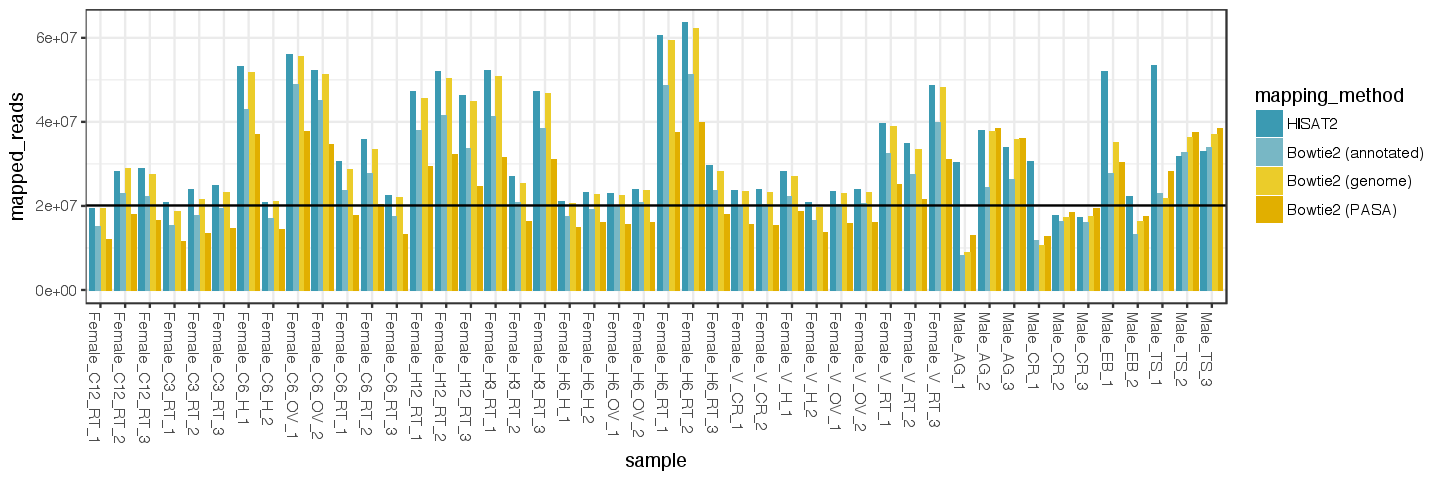

In [82]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_method)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000) +
    scale_fill_manual(values = wes_palette("Zissou"))
    

A couple of things to note here. Not surprisingly, the Trinity mapping has the highest number of mapped reads across samples, while the HISAT2 genome mapping has the lowest (this is reflected in the percentage of mapping as well; see the MultiQC output from the Snakemake pipeline). Another thing to note is that, for the paired-end male data, there is no difference in the number of mapped reads between the HISAT2 and Trinity bowtie2 alignments, suggesting the genome divergence issues are mitigated by paired-end data. 

Now we can look at the appropriate cutoffs for filtering using Brian Haas' method. To do this we count the genes acrtoss a range of minimum TPM values. The eXpress output we used generates a file that can be used to generate this matrix (see Trinity online guidelines). We'll load those two files for the genom- and Trinity-based analyses:

In [83]:
a.bt2_cbmt = read.table("Genome/annotated_eXpress/annotated.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
g.bt2_cbmt = read.table("Genome/eXpress/genome.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
pasa.bt2_cbmt = read.table("Trinity/pasa/eXpress/pasa.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)

For the HISAT@ data we have to write out the newly made TPM table and execute the minTPM script:

In [84]:
write.table(tpm_hisat2, "tmpFile.tpm", quote = F, sep = "\t")
system('~/Programs/trinityrnaseq-2.1.1/util/misc/count_matrix_features_given_MIN_TPM_threshold.pl tmpFile.tpm > tmpMin.tpm')
hisat2_cbmt = read.table("tmpMin.tpm", header = T)
system('rm tmpFile.tpm tmpMin.tpm')

First extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [85]:
hisat2_cbmt.sub = hisat2_cbmt[hisat2_cbmt[,1] > -100 & hisat2_cbmt[,1] < -10,]
a.bt2_cbmt.sub = a.bt2_cbmt[a.bt2_cbmt[,1] > -100 & a.bt2_cbmt[,1] < -10,]
g.bt2_cbmt.sub = g.bt2_cbmt[g.bt2_cbmt[,1] > -100 & g.bt2_cbmt[,1] < -10,]
pasa.bt2_cbmt.sub = pasa.bt2_cbmt[pasa.bt2_cbmt[,1] > -100 & pasa.bt2_cbmt[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [86]:
hisat2_cbmt.sub_fit = lm(hisat2_cbmt.sub[,2] ~ hisat2_cbmt.sub[,1])
print(hisat2_cbmt.sub_fit)

a.bt2_cbmt.sub_fit = lm(a.bt2_cbmt.sub[,2] ~ a.bt2_cbmt.sub[,1])
print(a.bt2_cbmt.sub_fit)

g.bt2_cbmt.sub_fit = lm(g.bt2_cbmt.sub[,2] ~ g.bt2_cbmt.sub[,1])
print(g.bt2_cbmt.sub_fit)

pasa.bt2_cbmt.sub_fit = lm(pasa.bt2_cbmt.sub[,2] ~ pasa.bt2_cbmt.sub[,1])
print(pasa.bt2_cbmt.sub_fit)


Call:
lm(formula = hisat2_cbmt.sub[, 2] ~ hisat2_cbmt.sub[, 1])

Coefficients:
         (Intercept)  hisat2_cbmt.sub[, 1]  
            11411.10                 73.33  


Call:
lm(formula = a.bt2_cbmt.sub[, 2] ~ a.bt2_cbmt.sub[, 1])

Coefficients:
        (Intercept)  a.bt2_cbmt.sub[, 1]  
           11534.67                76.03  


Call:
lm(formula = g.bt2_cbmt.sub[, 2] ~ g.bt2_cbmt.sub[, 1])

Coefficients:
        (Intercept)  g.bt2_cbmt.sub[, 1]  
            15086.0                113.5  


Call:
lm(formula = pasa.bt2_cbmt.sub[, 2] ~ pasa.bt2_cbmt.sub[, 1])

Coefficients:
           (Intercept)  pasa.bt2_cbmt.sub[, 1]  
               18918.9                   149.8  



Combine both matrices before plotting:

Warning message:
"Removed 5463 rows containing missing values (geom_point)."

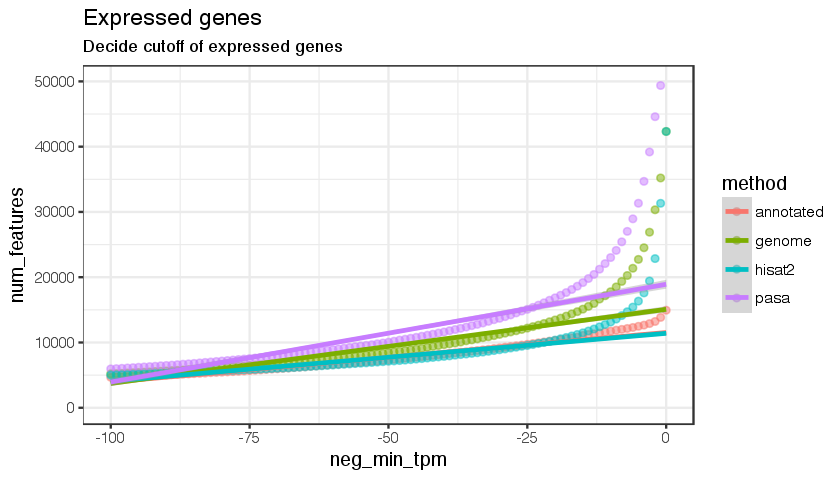

In [87]:
a.bt2_cbmt.sub$method = "annotated"
g.bt2_cbmt.sub$method = "genome"
pasa.bt2_cbmt.sub$method = "pasa"
hisat2_cbmt.sub$method = "hisat2"
cbmtSub = rbind(a.bt2_cbmt.sub,g.bt2_cbmt.sub,pasa.bt2_cbmt.sub,hisat2_cbmt.sub)

a.bt2_cbmt$method = "annotated"
g.bt2_cbmt$method = "genome"
pasa.bt2_cbmt$method = "pasa"
hisat2_cbmt$method = "hisat2"
cbmtMatrix = rbind(a.bt2_cbmt,g.bt2_cbmt,pasa.bt2_cbmt,hisat2_cbmt)

options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(cbmtMatrix, aes(neg_min_tpm, num_features, colour = method)) + 
    geom_point(alpha = 0.5) +  
    scale_x_continuous(limits=c(-100,0)) + 
    scale_y_continuous(limits=c(0,50000)) + 
    geom_smooth(data=cbmtSub, method = "lm",fullrange=TRUE, size = 1) + 
#     geom_hline(yintercept = 35028.1, colour = "green", linestyle = "dashed") + 
#     geom_hline(yintercept = 13173.37, colour = "orange") + 
    ggtitle("Expressed genes", subtitle = "Decide cutoff of expressed genes") +
    theme_bw()

In the Trinity analysis, out of 105593 "genes", roughly 35000 should remain after filtering lowly expressed genes. Simmilarly, 13000 out of ~20000 genes should remain in the genome analysis. Filtering should be performed on subsetted matrices for each analysis later because the threshold for the whole matrix tends to be too high, but we'll see what it is here. First, obtain the counts per million "CPM" matrix:

In [88]:
cpm_hisat2 <- cpm(counts_hisat2)
cpm_bt2.fbgn <- cpm(counts_bt2.fbgn)
cpm_bt2.mstrg <- cpm(counts_bt2.mstrg)
cpm_bt2.pasa <- cpm(counts_bt2.pasa)

For now, let's set the minimum CPM to 10, and generate a logical matrix for CPM > 10:

In [92]:
thresh_hisat2 <- cpm_hisat2 > 10
thresh_bt2.fbgn <- cpm_bt2.fbgn > 10
thresh_bt2.mstrg <- cpm_bt2.mstrg > 10
thresh_bt2.pasa <- cpm_bt2.pasa > 10

We would like to keep genes that have at least 2 "TRUE"s in each row of thresh:

In [93]:
keep_hisat2 <- rowSums(thresh_hisat2) >= 2
keep_bt2.fbgn <- rowSums(thresh_bt2.fbgn) >= 2
keep_bt2.mstrg <- rowSums(thresh_bt2.mstrg) >= 2
keep_bt2.pasa<- rowSums(thresh_bt2.pasa) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [94]:
countsKeep_hisat2 <- counts_hisat2[keep_hisat2,]
dim(countsKeep_hisat2)

countsKeep_bt2.fbgn <- counts_bt2.fbgn[keep_bt2.fbgn,]
dim(countsKeep_bt2.fbgn)

countsKeep_bt2.mstrg <- counts_bt2.mstrg[keep_bt2.mstrg,]
dim(countsKeep_bt2.mstrg)

countsKeep_bt2.pasa <- counts_bt2.pasa[keep_bt2.pasa,]
dim(countsKeep_bt2.pasa)

[1] 13907    46

[1] 11301    46

[1] 15518    46

[1] 19942    46

So a filter of 10 CPM brings the count matrix to the expected number of genes using Brian Haas' method. We would like to know what the CPM values correspond to in terms of raw counts. To do this, we'll plot CPM vs. counts for each sample. (look at the last 30)

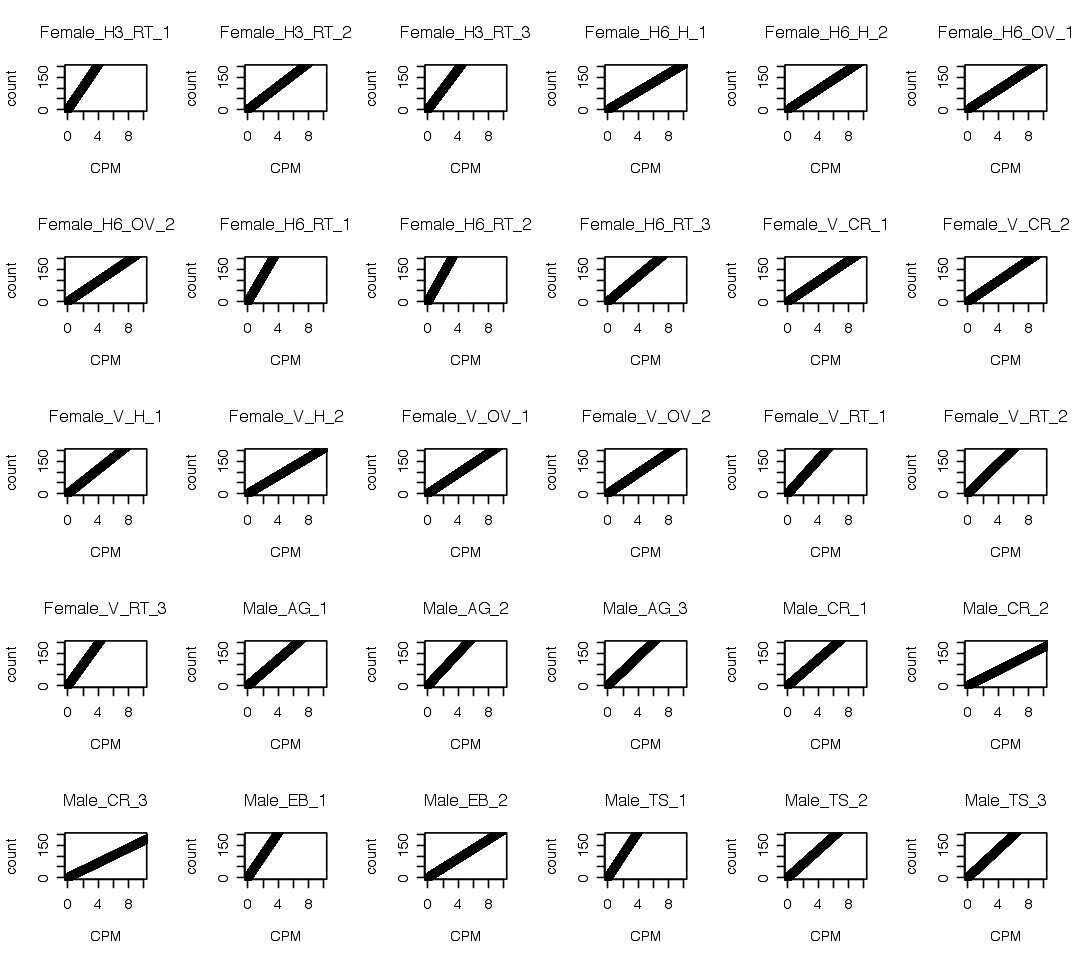

In [95]:
options(repr.plot.width = 9, repr.plot.height = 8)
par(mfrow=c(5,6))
for(i in seq(from=17, to=46, by=1)){
  plot(cpm_hisat2[,i],counts_hisat2[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
  title(colnames(cpm_hisat2)[i])
}

There's a range of correpondence between CPM values and raw counts. In general 10CPM seems to correspond to ~200 in raw counts.

## Differential Expression (annotated, genome-based analysis)

### Tissue-biased genes

In the first portion of the differential expression analysis we'll look at genes that show tissue-biased expression in females. We'll perform the analysis for the genome-based analysis and Trinity-based analysis separately.

First we'll subset the matrix to include virgin female tissue samples.

In [96]:
counts_bt2.fbgn.tissues = subset(counts_bt2.fbgn, select=grepl("Female_V", colnames(counts_bt2.fbgn)))

Now we can filter out low expression genes with a minimum 5 cpm cutoff (NOTE: Setting the threshold column number to 3 dramatically changes the number of tissue biased genes in this section).

In [131]:
cpm_bt2.fbgn.tissues <- cpm(counts_bt2.fbgn.tissues)
thresh_v.bt2.fbgn <- cpm_bt2.fbgn.tissues > 5
## look at number of columns with above requirements
table(rowSums(thresh_v.bt2.fbgn))

countsKeep_v.bt2.fbgn <- rowSums(thresh_v.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.tissues <- counts_bt2.fbgn.tissues[countsKeep_v.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.tissues)


## Clean-up
rm(cpm_bt2.fbgn.tissues, countsKeep_v.bt2.fbgn, thresh_v.bt2.fbgn)


   0    1    2    3    4    5    6    7    8    9 
4963  224 1465  642  492  324  246  836  516 5236 

[1] 9757    9

We'll also subset the samplesData object to only include the virgin tissue and male samples:

In [100]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
head(sampleInfo.v, n =2)

,SampleName,Replicate,Sex,Tissue,Status,Time
27,Female_V_CR,Female_V_CR_1,female,carcass,virgin,virgin
28,Female_V_CR,Female_V_CR_2,female,carcass,virgin,virgin


We can now define groups for differential expression:

In [101]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate

Now we'll create the DGE object and fit the general linear model:

In [102]:
dgeList.v <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can add annotation information to the fit object, and put it in the genes slot:

In [141]:
Annots.a = merge(merge(melOrthsAll, trinotate_annotated, all=TRUE), dv1.06_features, all=TRUE)
annot.sum = unique(subset(Annots.g, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)
head(annot.sum, n = 2)

FBgn_ID,gene_name,SwissProt_BlastX_Description
FBgn0015205,140up,RPII140-upstream gene protein
FBgn0257406,18SrRNA:GJ25572,.


now create the annotation object:

In [142]:
# Extract annotation for genes in the fit object
ann.v = subset(Annots.a, FBgn_ID %in% rownames(dgeList.v_fit))
# convert factors to characters
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
# convert factors to characters, again
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.v) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.v$GeneID==rownames(dgeList.v_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.v_fit$genes = ann.v


TRUE 
9757 

A quick look at the dispersion stats:

In [105]:
summary(dgeList.v$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01993 0.02820 0.03700 0.05979 0.05430 2.15200 

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea voom object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

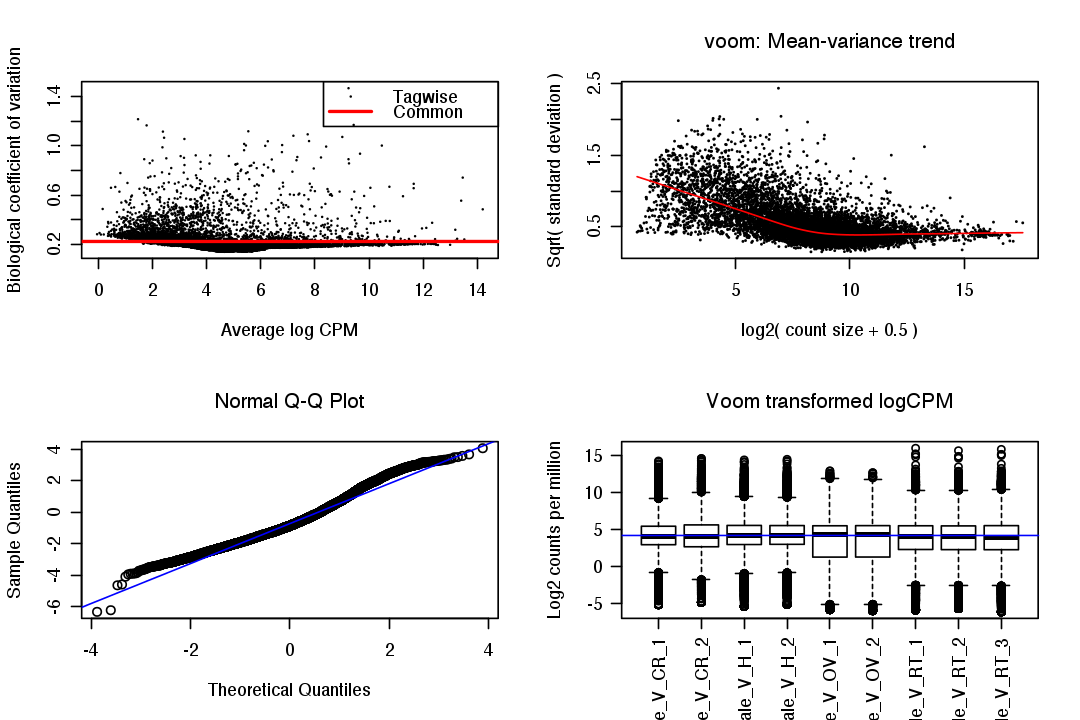

In [106]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [107]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.v$Replicate)

Replicates are grouping correctly. Another way to look at grouping is a heatmap of sample correlations:

for plotting:: min.raw: 0.280548033687719 max.raw: 1


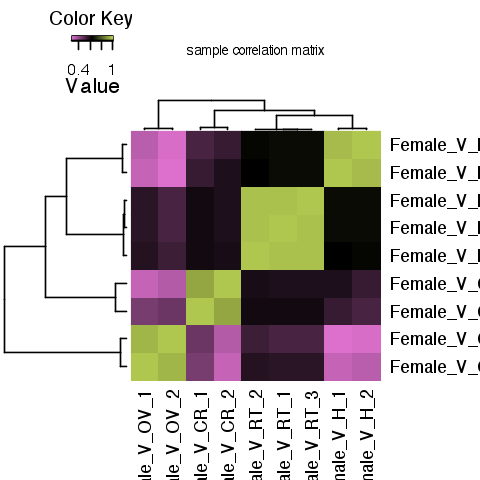

In [108]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.tissues+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 4, repr.plot.height =4)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [109]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

##### Reprotductive tract

In [110]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001)$GeneID
paste(length(repTract.list), " genes show RT-biased expression", sep = "")

[1] "283 genes show RT-biased expression"

###### Ovaries

In [111]:
lrt.v.ovaries <- glmLRT(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.ovaries.tTags <- topTags(lrt.v.ovaries, n = NULL)
lrt.v.ovaries.tTags.table <- lrt.v.ovaries.tTags$table
ovaries.list<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001)$GeneID
paste(length(ovaries.list), " show ovary-biased expression", sep = "")

[1] "776 show ovary-biased expression"

###### Head:

In [112]:
lrt.v.head <- glmLRT(dgeList.v_fit, contrast = cont.v.head)
lrt.v.head.tTags <- topTags(lrt.v.head, n = NULL)
lrt.v.head.tTags.table <- lrt.v.head.tTags$table
head.list<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001)$GeneID
paste(length(head.list), " show head-biased expression", sep = "")

[1] "740 show head-biased expression"

We can generate a tissue-biased factor table to annotate a simple heatmap of the tissue-biased genes (this can also be used for GO analysis later):

In [113]:
RT_factors = as.data.frame(repTract.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = repTract.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(head.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = head.list
H_factors = subset(H_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, OV_factors, H_factors)
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [114]:
meanTPM_v_bt2.fbgn = subset(tpmMatrix_bt2.fbgn, rownames(tpm_bt2.fbgn) %in% rownames(virgin.factor.labeling))
meanTPM_v_bt2.fbgn = subset(meanTPM_v_bt2.fbgn, select=grepl("Female_V", colnames(meanTPM_v_bt2.fbgn)))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the heatmap3 package):

In [115]:
data = meanTPM_v_bt2.fbgn
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(virgin.factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#e1526d", "#b85516", "#647700")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

Now we plot it:

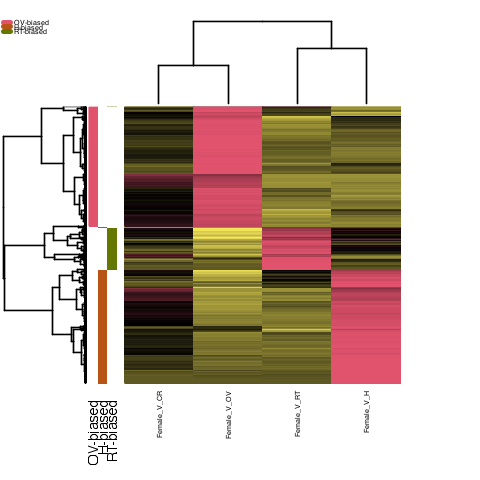

In [116]:
options(repr.plot.width = 4, repr.plot.height = 4)
heatmap3(heatmap_data, 
         col=myheatcol, 
         cexCol = 0.5, 
         labRow = "", 
         legendfun=function() showLegend(legend=c("OV-biased", "H-biased", "RT-biased"), col=c("#e1526d", "#b85516", "#647700"), cex = 0.5), 
        cex.main=0.4, 
             RowSideColors = geneFactorAnnotations)

#### Gene Ontology

Process the gene length information and GO annotation files for GOseq:

In [120]:
GO_info_listed = apply(GOinfo_annotated, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GOinfo_annotated)
features_with_GO = rownames(GOinfo_annotated)
lengths_features_with_GO = a.gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

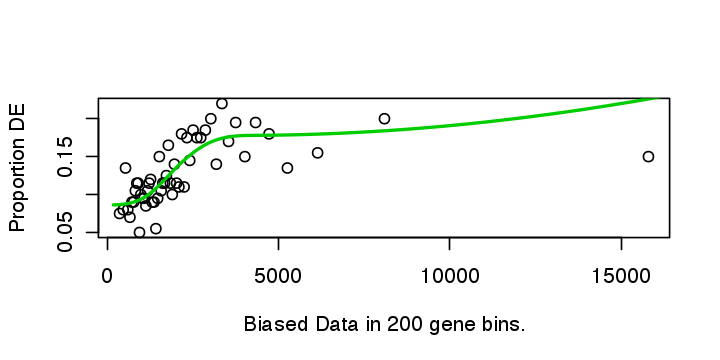

In [122]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [123]:
GO_enriched_list = list()

for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling)[virgin.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: RT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: OV-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: H-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Output the significant GO terms to the Results folder:

In [127]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_results-female_tissue-biased_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

We can take a look at the output format. Here's an example of how to plot it (for the RT-biased category):

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
"Removed 145 rows containing missing values (geom_point)."

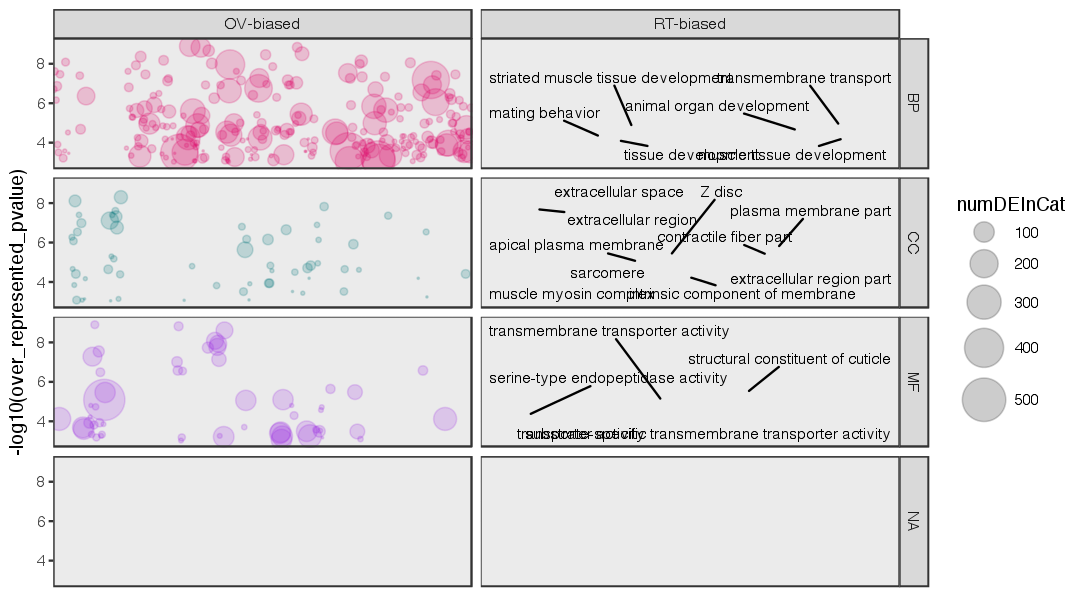

In [124]:
### RT plot
options(repr.plot.width = 9, repr.plot.height = 5)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "OV-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~factor) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, factor == "RT-biased" & over_represented_FDR < 0.05), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))
#dev.off()

### Reproductive tract post-mating contrasts:

In [167]:
## Define good replicates
RT_GoodReps = as.character(subset(sampleInfo, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1" & Tissue == "repTract")$Replicate)

Create RT-specific count matrix 

In [168]:
counts_bt2.fbgn.RT = subset(counts_bt2.fbgn, select=grepl("RT", colnames(counts_bt2.fbgn)))
counts_bt2.fbgn.RT = subset(counts_bt2.fbgn.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 2:

In [169]:
cpm_bt2.fbgn.RT <- cpm(counts_bt2.fbgn.RT)
thresh_RT.bt2.fbgn <- cpm_bt2.fbgn.RT > 2

## look at number of columns with above requirements
table(rowSums(thresh_RT.bt2.fbgn))

countsKeep_RT.bt2.fbgn <- rowSums(thresh_RT.bt2.fbgn) >= 3
countsFiltered_bt2.fbgn.RT <- counts_bt2.fbgn.RT[countsKeep_RT.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.RT)

## Clean-up
rm(cpm_bt2.fbgn.RT, countsKeep_RT.bt2.fbgn, thresh_RT.bt2.fbgn)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6169  220  101   73   61   51   40   32   37   40   38   32   34   33   44   53 
  16   17   18   19 
  53   77  122 7634 

[1] 8454   19

We'll also subset the samplesInfo object to only include the RT samples:

In [170]:
sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# remove rogue replicates:
sampleInfo.pm = subset(sampleInfo.pm, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1")
head(sampleInfo.pm)

SampleName,Replicate,Sex,Tissue,Status,Time
Female_C12_RT,Female_C12_RT_1,female,repTract,conspecific,12hpm
Female_C12_RT,Female_C12_RT_2,female,repTract,conspecific,12hpm
Female_C12_RT,Female_C12_RT_3,female,repTract,conspecific,12hpm
Female_C3_RT,Female_C3_RT_1,female,repTract,conspecific,3hpm
Female_C3_RT,Female_C3_RT_2,female,repTract,conspecific,3hpm
Female_C3_RT,Female_C3_RT_3,female,repTract,conspecific,3hpm


#### 1. Comparing postmating samples to virgin:

We'll first define the relevant groups for this comparison, making the `virgin` sample the control:

In [220]:
## Will need to relevel the Status grouping to make virgin control
sampleInfo.pm$Status = factor(sampleInfo.pm$Status, levels = c("virgin", "conspecific", "heterospecific"))
sampleInfo.pm$Status <- relevel(sampleInfo.pm$Status, ref = "virgin")
groups.pm <- factor(sampleInfo.pm$Status)
design.pm <- model.matrix(~groups.pm)
colnames(design.pm) <- levels(groups.pm)
rownames(design.pm) <- sampleInfo.pm$Replicate

In [221]:
design.pm

,virgin,conspecific,heterospecific
Female_C12_RT_1,1,1,0
Female_C12_RT_2,1,1,0
Female_C12_RT_3,1,1,0
Female_C3_RT_1,1,1,0
Female_C3_RT_2,1,1,0
Female_C3_RT_3,1,1,0
Female_C6_RT_1,1,1,0
Female_C6_RT_2,1,1,0
Female_C6_RT_3,1,1,0
Female_H12_RT_1,1,0,1


Create edgeR DE object and run glmFit

In [172]:
dgeList.pm.1 <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pm.1)
dgeList.pm.1 <- calcNormFactors(dgeList.pm.1)
dgeList.pm.1 <- estimateCommonDisp(dgeList.pm.1)
dgeList.pm.1 <- estimateTagwiseDisp(dgeList.pm.1)
dgeList.pm.1_fit <- glmFit(dgeList.pm.1, design.pm.1)

Let's add the annotation information to this fit object:

In [212]:
# Extract annotation for genes in the fit object
ann.pm.1 = subset(Annots.a, FBgn_ID %in% rownames(dgeList.pm.1_fit))
ann.pm.1 = subset(ann.pm.1, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pm.1 = data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pm.1 = ann.pm.1[match(rownames(dgeList.pm.1_fit), ann.pm.1$FBgn_ID),]
# convert factors to characters, again
ann.pm.1 <- data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pm.1) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pm.1$GeneID==rownames(dgeList.pm.1_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pm.1_fit$genes = ann.pm.1


TRUE 
8454 

Also, check the tagwise dispersion summary:

In [213]:
summary(dgeList.pm.1$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.007668 0.013310 0.018260 0.039990 0.029740 2.064000 

Looks decent. Now let's look at the biological coefficient of variation to examine variability within each sample. It would also be useful to generate a voom object as an aside to compare to the edgeR analyses (from this object we can look at the mean-variance trend). Also, let's generate a QQ-plot.

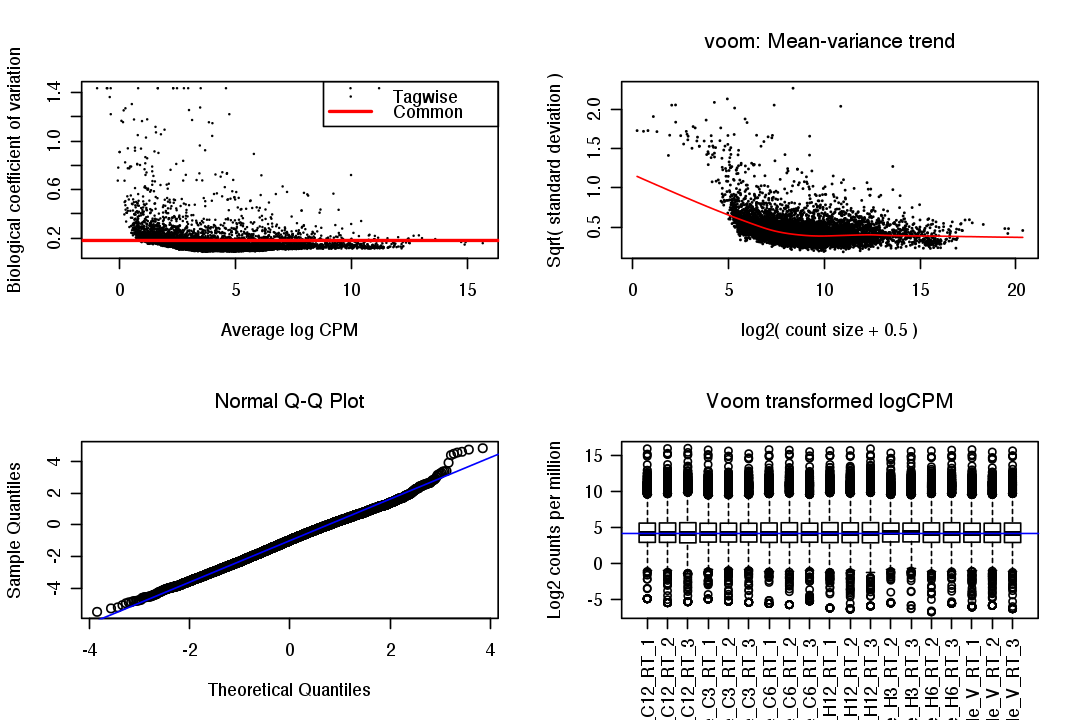

In [214]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pm.1)
# mean-variance trend
pm.1.voom = voom(dgeList.pm.1, design.pm.1, plot=TRUE)
# QQ-plot
g.pm.1 <- gof(dgeList.pm.1_fit)
z.pm.1 <- zscoreGamma(g.pm.1$gof.statistics,shape=g.pm.1$df/2,scale=2)
qqnorm(z.pm.1); qqline(z.pm.1, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pm.1.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(pm.1.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

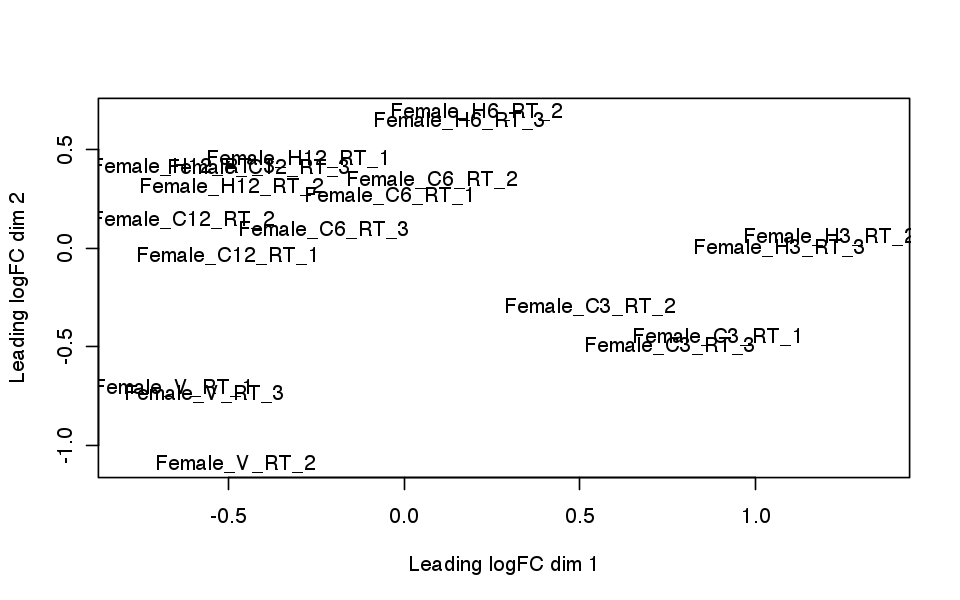

In [215]:
# ## colour samples by tissue-type
# col.Status <- c("#feaaf8",
# "#347500",
# "#0180ba",
# "#b0d17d")[sampleInfo.pm$Status]
# chr.time <- c(21:24)[sampleInfo.pm$time]

options(repr.plot.width = 8, repr.plot.height = 5)
plotMDS(dgeList.pm.1)
# legend("topright",legend=levels(sampleInfo.pm$Status), fill = c("#feaaf8",
# "#347500",
# "#0180ba",
# "#b0d17d"), cex = 1)
# legend("bottomright",legend=levels(sampleInfo.pm$time), pch = c(21:24), cex = 1)
# # Add a title
# title("reproductive tract samples")

Can also look at int interactively with Glimma:

In [216]:
glMDSPlot(dgeList.pm.1, groups = sampleInfo.pm, labels = sampleInfo.pm$Replicate)

Replicates seem to largely group together in the first component, but two samples (H3_RT_1 and H6_RT_1) deviate from their sisters a bit. We'll consider removing those from the analysis later. For now, let's look at samples correlation:

for plotting:: min.raw: 0.949935629619086 max.raw: 1


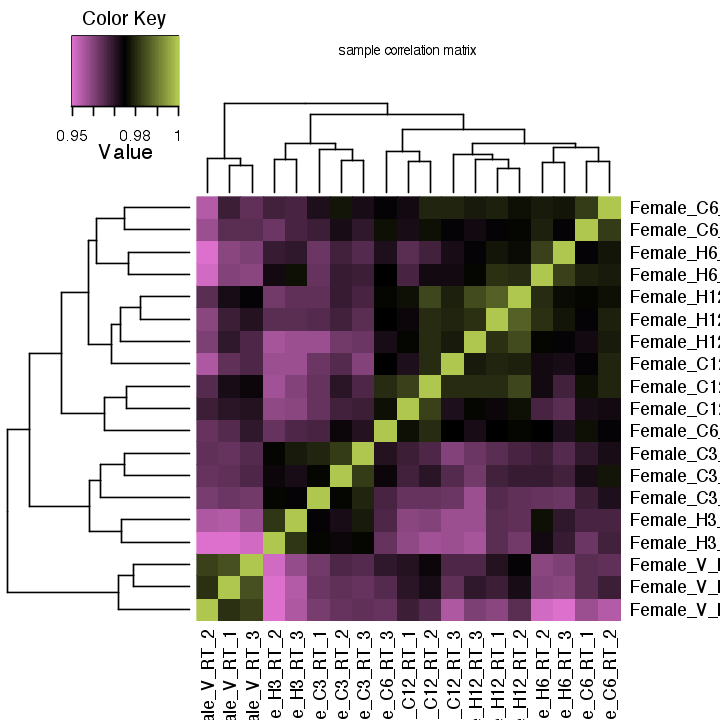

In [178]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.RT+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

The correlations are mostly good. The three samples that aren't grouping where they should are:
C6_RT_3
H3_RT_1
H6_RT_1
Now we can identify differentially expressed genes between postmating and virgin RT samples. First we'll compare conspecific to vrigin (coef=2), and use the log-fold cutoff of 1 (2-fold).

In [179]:
lrt_con.v.vir <- glmTreat(dgeList.pm.1_fit, coef =2, lfc =1)

#extract gene list of DE genes
DE.genes_con.v.virg <- subset(topTags(lrt_con.v.vir, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_con.v.virg

[1] "FBgn0210109" "FBgn0206349" "FBgn0207142" "FBgn0201082" "FBgn0208092"
 [6] "FBgn0199412" "FBgn0206457" "FBgn0207331" "FBgn0211009" "FBgn0200611"
[11] "FBgn0211115" "FBgn0202281" "FBgn0282300" "FBgn0209847" "FBgn0210992"
[16] "FBgn0211089" "FBgn0282057" "FBgn0068560" "FBgn0201334" "FBgn0282877"
[21] "FBgn0068555"

... Now compare heterospecific to virgin:

In [180]:
lrt_het.v.vir <- glmTreat(dgeList.pm.1_fit, coef =3, lfc =1)

#extract gene list of DE genes
DE.genes_het.v.virg <- subset(topTags(lrt_het.v.vir, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_het.v.virg

[1] "FBgn0210109" "FBgn0206349" "FBgn0207142" "FBgn0201082" "FBgn0207331"
 [6] "FBgn0206457" "FBgn0283370" "FBgn0208092" "FBgn0199412" "FBgn0211115"
[11] "FBgn0211009" "FBgn0209590" "FBgn0282300" "FBgn0211089" "FBgn0197773"
[16] "FBgn0202416" "FBgn0209847" "FBgn0209342" "FBgn0211511" "FBgn0207005"
[21] "FBgn0282920" "FBgn0256676" "FBgn0282057" "FBgn0282764" "FBgn0283309"
[26] "FBgn0200611" "FBgn0282877" "FBgn0199547" "FBgn0210992" "FBgn0207804"
[31] "FBgn0208031" "FBgn0282243" "FBgn0200894" "FBgn0201305" "FBgn0211513"

We can make a venn diagram of the above gene lists.

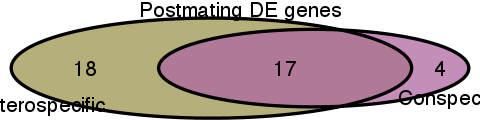

In [181]:
options(repr.plot.width = 4, repr.plot.height = 1)
RT_DE_vs.virgin_candidates <- list(Conspecific = DE.genes_con.v.virg, Heterospecific = DE.genes_het.v.virg)
RT_DE_vs.virgin_combs <- unlist(lapply(1:length(RT_DE_vs.virgin_candidates), function(j) combn(names(RT_DE_vs.virgin_candidates), j, simplify = FALSE)), recursive = FALSE)
names(RT_DE_vs.virgin_combs) <- sapply(RT_DE_vs.virgin_combs, function(i) paste0(i, collapse = ","))
RT_DE_vs.virgin_elements <- lapply(RT_DE_vs.virgin_combs, function(i) Setdiff(RT_DE_vs.virgin_candidates[i], RT_DE_vs.virgin_candidates[setdiff(names(RT_DE_vs.virgin_candidates), i)]))
RT_DE_vs.virgin_Vdiag<-venn.diagram(RT_DE_vs.virgin_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "Postmating DE genes")
grid.arrange(gTree(children=RT_DE_vs.virgin_Vdiag))

We can output PDFs of individual gene plots:

In [182]:
# DE.genes_het.v.virg.Plots = suppressMessages(lapply(DE.genes_het.v.virg, boxPlotPM, object = subset(g.TPM.table, tissue == "Fem. RT")))
# ggsave("Snakemake_output_files/Plots/g.DE.genes_het.v.virg.pdf", marrangeGrob(grobs = DE.genes_het.v.virg.Plots, nrow = 3, ncol = 2))

# DE.genes_con.v.virg.Plots = suppressMessages(lapply(DE.genes_con.v.virg, boxPlotPM, object = subset(g.TPM.table, tissue == "Fem. RT")))
# ggsave("Snakemake_output_files/Plots/g.DE.genes_con.v.virg.pdf", marrangeGrob(grobs = DE.genes_con.v.virg.Plots, nrow = 3, ncol = 2))

Some notable genes in the above lists:
1. Ecdysone-induced protein (GJ13863)
2. immune stuff: pirk, PGRP's (2), cecropin, Defensin (het only), GNBP-like3 (het only), Attacin (het only)
3. Serine proteinase stubble (scarface, het only)
4. elongation factor 2 (het only)

#### 2. Comparing heterospecific to conspecific RT samples

We can use the above design to test for overall DE between conspecific and heterospecific postmating samples:

In [183]:
lrt_con.v.het <- glmTreat(dgeList.pm.1_fit, contrast = c(0,-1,1), lfc =1)

#extract gene list of DE genes
DE.genes_con.v.het <- subset(topTags(lrt_con.v.het, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_con.v.het

[1] "FBgn0197773" "FBgn0209590" "FBgn0207711" "FBgn0208031" "FBgn0197774"
[6] "FBgn0013133" "FBgn0281939"

Here's a Volcano plot of those results:

In [217]:
dt.con.v.het = decideTestsDGE(lrt_con.v.het)
glXYPlot(x=lrt_con.v.het$table$logFC, y=-log10(lrt_con.v.het$table$PValue), xlab="logFC", ylab="logodds", status=dt.con.v.het, groups=sampleInfo.pm$SampleName, side.main="gene_name", anno = ann.pm.1, counts = dgeList.pm.1)

Let's make barplots of those genes:

In [78]:
DE.genes_con.v.het.Plots = suppressMessages(lapply(DE.genes_con.v.het, boxPlotPM, object = subset(g.TPM.table, tissue == "Fem. RT")))
# ggsave("Snakemake_output_files/Plots/g.DE.genes_con.v.het.pdf", marrangeGrob(grobs = DE.genes_con.v.het.Plots, nrow = 3, ncol = 2))

Out of the 6 gene that are differentially expressed between all con- and heterospecific postmating time points (Defensin, Attacin, elongation factor 2, Larval cuticle protein 5, one unknown), two are clearly antimicropial peptides and are upregulated in the heterospecific samples. The gene that is upregulated in the conspecific condition (ninaE) is a rhodospin gene, and looks like one of the conspcific 6hpm replicates is responsible for the difference, thus likely a false-positive.

Using this approach, which looks for significant differences by averaging across all three time points, only six genes show up as significant between conspecific and heterospecific samples. To detect more DE genes, we'll need to compare samples within each postmating time point.

#### 3. Comparing each postmating time point to the virgin RT sample

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [191]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$Time, sep="."))
sampleInfo.pm.3 <- cbind(sampleInfo.pm, Group=Status.time)
sampleInfo.pm.3$Group <- relevel(sampleInfo.pm.3$Group, ref = "virgin.virgin")

groups.pm.3 <- factor(sampleInfo.pm.3$Group)
design.pm.3 <- model.matrix(~groups.pm.3)
colnames(design.pm.3) <- levels(groups.pm.3)
rownames(design.pm.3) <- sampleInfo.pm.3$Replicate

Create edgeR DE object and run glmFit

In [192]:
dgeList.pm.3 <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pm.3)
dgeList.pm.3 <- calcNormFactors(dgeList.pm.3)
dgeList.pm.3 <- estimateCommonDisp(dgeList.pm.3)
dgeList.pm.3 <- estimateTagwiseDisp(dgeList.pm.3)
dgeList.pm.3_fit <- glmFit(dgeList.pm.3, design.pm.3)

Let's add the annotation information to this fit object:

In [218]:
# Extract annotation for genes in the fit object
ann.pm.3 = subset(Annots.a, FBgn_ID %in% rownames(dgeList.pm.3_fit))
ann.pm.3 = subset(ann.pm.3, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pm.3 = data.frame(lapply(ann.pm.3, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pm.3 = ann.pm.3[match(rownames(dgeList.pm.3_fit), ann.pm.3$FBgn_ID),]
# convert factors to characters, again
ann.pm.3 <- data.frame(lapply(ann.pm.3, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pm.3) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pm.3$GeneID==rownames(dgeList.pm.3_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pm.3_fit$genes = ann.pm.3


TRUE 
8454 

Also, check the tagwise dispersion summary:

In [194]:
summary(dgeList.pm.3$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004953 0.008064 0.010880 0.024680 0.018190 1.105000 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

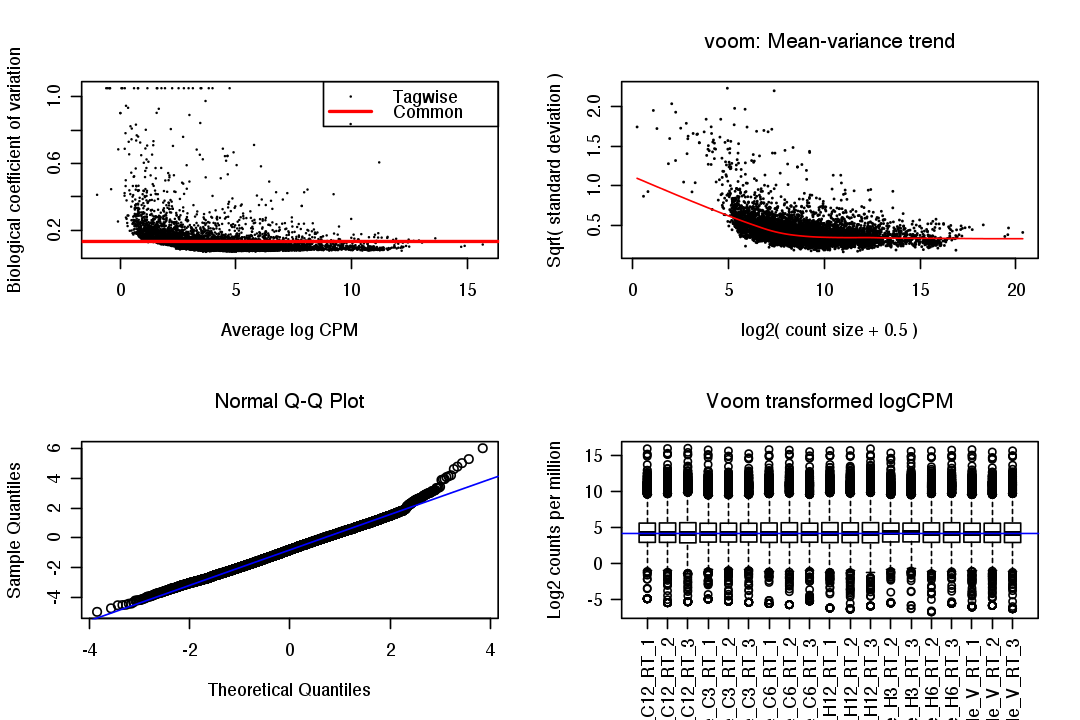

In [195]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pm.3)
# mean-variance trend
pm.3.voom = voom(dgeList.pm.3, design.pm.3, plot=TRUE)
# QQ-plot
g.pm.3 <- gof(dgeList.pm.3_fit)
z.pm.3 <- zscoreGamma(g.pm.3$gof.statistics,shape=g.pm.3$df/2,scale=2)
qqnorm(z.pm.3); qqline(z.pm.3, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pm.3.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(pm.3.voom$E),col="blue")

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference:

In [196]:
glmT_C3.v.vir <- glmTreat(dgeList.pm.3_fit, coef =3, lfc =1)
glmT_C6.v.vir <- glmTreat(dgeList.pm.3_fit, coef =4, lfc =1)
glmT_C12.v.vir <- glmTreat(dgeList.pm.3_fit, coef =2, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pm.3_fit, coef =6, lfc =1)
glmT_H6.v.vir <- glmTreat(dgeList.pm.3_fit, coef =7, lfc =1)
glmT_H12.v.vir <- glmTreat(dgeList.pm.3_fit, coef =5, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [197]:
DE.genes_C3.v.vir_up <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C6.v.vir_up <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C12.v.vir_up <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H3.v.vir_up <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H6.v.vir_up <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H12.v.vir_up <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID

... and downregulated ones...

In [198]:
DE.genes_C3.v.vir_down <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C6.v.vir_down <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C12.v.vir_down <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H3.v.vir_down <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H6.v.vir_down <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H12.v.vir_down <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID

What we can do now is compare and contrasts these individual lists, capture the overlap between them, and plot Venn diagrams. First, let's aggregate by cross type:

In [199]:
RT_UP_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_up, Heterospecific = DE.genes_H3.v.vir_up)
RT_UP_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_up, Heterospecific = DE.genes_H6.v.vir_up)
RT_UP_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_up, Heterospecific = DE.genes_H12.v.vir_up)
RT_Down_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_down, Heterospecific = DE.genes_H3.v.vir_down)
RT_Down_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_down, Heterospecific = DE.genes_H6.v.vir_down)
RT_Down_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_down, Heterospecific = DE.genes_H12.v.vir_down)

Rearrange those into lists of lists, and partition by postmating time-point

In [200]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

Assign names to each combination (i.e., con and het):

In [201]:
names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

Now generate a list of each element:

In [202]:
RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

Now we generate the Venn diagram objects and plot them:

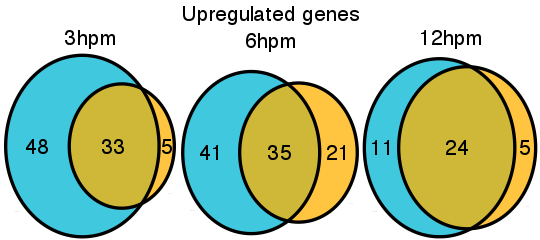

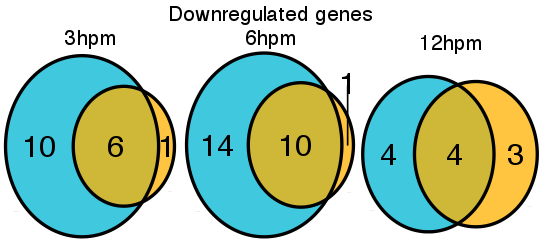

In [206]:
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
# "#3f5a2a",
# "#ffb200","#00b5d4"
options(repr.plot.width = 4.5, repr.plot.height = 2)
# pdf("~/Desktop/Venn_diag.pdf", width = 3, height = 1.5)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag), ncol = 3, top = "Upregulated genes")
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag), ncol = 3, top = "Downregulated genes")
# dev.off()

Before we can look at Glimma volcano plots, we need to run the decideTestsDGE for each glmTreat output:

In [207]:
dt_C3.v.vir = decideTestsDGE(glmT_C3.v.vir)
dt_C6.v.vir = decideTestsDGE(glmT_C6.v.vir)
dt_C12.v.vir = decideTestsDGE(glmT_C12.v.vir)
dt_H3.v.vir = decideTestsDGE(glmT_H3.v.vir)
dt_H6.v.vir = decideTestsDGE(glmT_H6.v.vir)
dt_H12.v.vir = decideTestsDGE(glmT_H12.v.vir)

Here's one example of a volcano plot between heterospecific 6hpm samples and virgins:

In [219]:
glXYPlot(x=glmT_H6.v.vir$table$logFC, y=-log10(glmT_H6.v.vir$table$PValue), xlab="logFC", ylab="logodds", status=dt_H6.v.vir, groups=sampleInfo.pm$SampleName, anno = ann.pm.3, side.main="gene_name", counts = dgeList.pm.3)

#### Analysis of all upregulated genes in all PM RT condition:

First we'll look at thos genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [94]:
nrow(g.meanTPMmatrix)

[1] 14944

In [115]:
length(unique(unlist(c(RT_Down_3hrs_elements, RT_Down_6hrs_elements, RT_Down_12hrs_elements))))

[1] 42

In [95]:
RT_upregulated_genes = unique(unlist(c(RT_UP_3hrs_elements, RT_UP_6hrs_elements, RT_UP_12hrs_elements)))
message(paste("There are ", length(RT_upregulated_genes), " upregulated genes", sep =""))
RT_upregulated_genes_matrix = subset(g.meanTPMmatrix, rownames(g.meanTPMmatrix) %in% RT_upregulated_genes)

RT_upregulated_genes_matrix = RT_upregulated_genes_matrix[ , grepl("RT", names(RT_upregulated_genes_matrix))]
RT_upregulated_genes_matrix_con = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_upregulated_genes_matrix_het = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 135 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

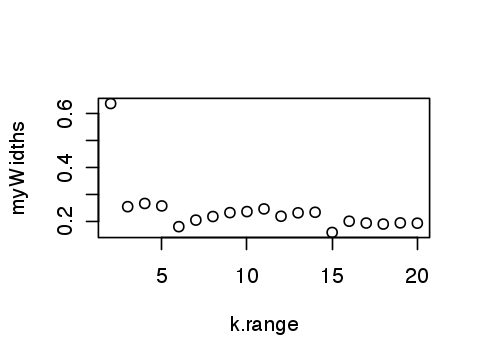

In [96]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_upregulated_genes_matrix)

Creudly, it looks like 11-13 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [97]:
data = RT_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=8)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

In [98]:
head(g.TPM.table)

replicate_id,gene_id,TPM,sample,replicate,tissue,sex,condition,time
Female_C12_RT_1,FBgn0013065,50.395,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm
Female_C12_RT_1,FBgn0013066,1.324,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm
Female_C12_RT_1,FBgn0013067,26.084,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm
Female_C12_RT_1,FBgn0013068,20.983,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm
Female_C12_RT_1,FBgn0013069,0.531,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm
Female_C12_RT_1,FBgn0013070,1.578,Female_C12_RT,1,Fem. RT,female,conspecific,12hpm


In [99]:
vetted_DE = read.table("abnormal_upregulated_genes_manually_inspected.txt", header = T, sep = "\t")
head(vetted_DE)

FBgn_ID,function.
FBgn0017815,immunity
FBgn0207711,immunity
FBgn0207804,immunity
FBgn0209590,immunity
FBgn0203480,immunity
FBgn0210579,immunity


Here we'll just generate some color parameters for each cluster:

In [100]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


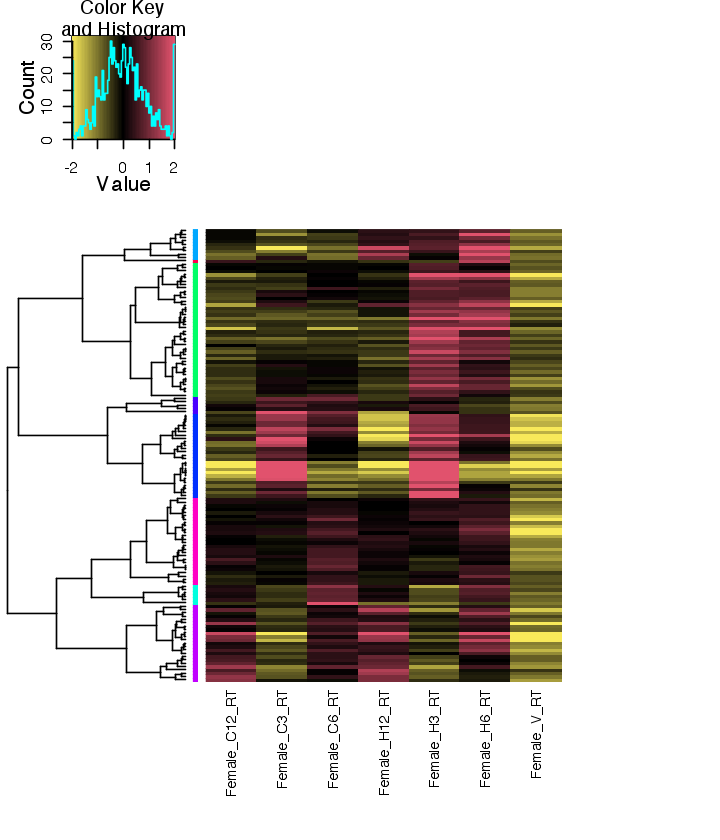

In [101]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [102]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [103]:
conSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

In [104]:
table(t(vetted_DE))


      FBgn0017815       FBgn0017817       FBgn0197572       FBgn0197687 
                1                 1                 1                 1 
      FBgn0197773       FBgn0199407       FBgn0200463       FBgn0201305 
                1                 1                 1                 1 
      FBgn0203480       FBgn0205175       FBgn0206553       FBgn0206847 
                2                 1                 1                 2 
      FBgn0207711       FBgn0207804       FBgn0208196       FBgn0208858 
                1                 1                 1                 1 
      FBgn0209342       FBgn0209566       FBgn0209590       FBgn0209713 
                1                 2                 1                 1 
      FBgn0209885       FBgn0210579       FBgn0211145       FBgn0281939 
                1                 1                 1                 2 
      FBgn0282818       FBgn0282918       FBgn0283370          immunity 
                1                 2               

In [105]:
newVetted = merge(subset(annot.sum, FBgn_ID %in% as.character(vetted_DE$FBgn_ID)), vetted_DE)
newVetted = merge(newVetted, melOrthsAll, by.x = "FBgn_ID", by.y = "FBgn_ID")

In [106]:
str(newVetted)

'data.frame':	24 obs. of  5 variables:
 $ FBgn_ID                     : Factor w/ 15078 levels "FBgn0013065",..: 89 91 393 490 561 1816 2654 3325 4908 4908 ...
 $ gene_name                   : Factor w/ 15078 levels "140up","18SrRNA:GJ25572",..: 328 326 594 696 773 2180 3106 3847 5623 5623 ...
 $ SwissProt_BlastX_Description: chr  "Cecropin-1/3" "Cecropin-2" "Suppressor of cytokine signaling 5" "Serine protease easter" ...
 $ function.                   : Factor w/ 6 levels "immunity","Jak/Statsignaling",..: 1 1 2 5 6 6 6 4 1 3 ...
 $ mel_GeneSymbol              : chr  "CecA1, CecA2, CecC" "CecA1, CecA2, CecC" "Socs36E" "CG9733" ...


In [107]:
intereseting.gene.TPM.table = merge(g.TPM.table, newVetted, by.x = "gene_id", by.y = "FBgn_ID")

In [108]:
head(intereseting.gene.TPM.table)

gene_id,replicate_id,TPM,sample,replicate,tissue,sex,condition,time,gene_name,SwissProt_BlastX_Description,function.,mel_GeneSymbol
FBgn0017815,Female_H3_RT_2,25.183,Female_H3_RT,2,Fem. RT,female,heterospecific,3hpm,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"
FBgn0017815,Female_H6_OV_1,5.754,Female_H6_OV,1,ovaries,female,heterospecific,6hpm,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"
FBgn0017815,Female_H12_RT_3,0.230,Female_H12_RT,3,Fem. RT,female,heterospecific,12hpm,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"
FBgn0017815,Male_CR_1,4.644,Male_CR,1,carcass,male,conspecific,24hpm,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"
FBgn0017815,Male_AG_3,0.000,Male_AG,3,AG,male,conspecific,24hpm,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"
FBgn0017815,Female_V_OV_1,0.000,Female_V_OV,1,ovaries,female,virgin,virgin,Cec3,Cecropin-1/3,immunity,"CecA1, CecA2, CecC"


In [109]:
plotThese <- function (gene) 
{
    p <- ggplot(subset(intereseting.gene.TPM.table, gene_id == gene & tissue == "Fem. RT"), aes(time, TPM, colour = condition)) + 
            geom_boxplot(position = "dodge", outlier.size = 0, width = 0.3) + 
    geom_point(pch = 21, position = position_jitterdodge(), aes(colour = condition)) + 
#     facet_grid(~SwissProt_BlastX_Description, scales = "free_y", space = "free_x") + 
    labs(title = paste(unique(subset(intereseting.gene.TPM.table, gene_id == gene & tissue == "Fem. RT")$mel_GeneSymbol, sep = "")), size = 10) + 
    theme_minimal() +
    scale_colour_manual(values = c("#3f5a2a","#ffb200","#00b5d4")) +
    theme(legend.position = "none", axis.title.x = element_blank())
    
    return(p)
}

In [114]:
pdf("~/Desktop/example_gene_boxPlots.pdf", width = 2.5, height = 1.5)
ggplot(subset(intereseting.gene.TPM.table, gene_id == "FBgn0017815" & tissue == "Fem. RT"), aes(time, TPM, colour = condition)) + 
            geom_boxplot(position = "dodge", outlier.size = 0, width = 0.3) + 
    geom_point(pch = 21, position = position_jitterdodge(), aes(colour = condition)) + 
#     facet_grid(~SwissProt_BlastX_Description, scales = "free_y", space = "free_x") + 
    labs(title = paste(unique(subset(intereseting.gene.TPM.table, gene_id == "FBgn0017815" & tissue == "Fem. RT")$mel_GeneSymbol, sep = "")), size = 10) + 
    theme_minimal() +
    scale_colour_manual(values = c("#3f5a2a","#ffb200","#00b5d4"))
dev.off()

pdf 
  2

In [110]:
pdf("~/Desktop/immune_gene_boxPlots.pdf", width = 2.5, height = 1.5)
lapply(as.character(subset(vetted_DE, function. == "immunity")$FBgn_ID), plotThese)
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


pdf 
  2

In [111]:
pdf("~/Desktop/JakStatsignaling_gene_boxPlots.pdf", width = 2.5, height = 1.5)
lapply(as.character(subset(vetted_DE, function. == "Jak/Statsignaling")$FBgn_ID), plotThese)
dev.off()

[[1]]


pdf 
  2

In [112]:
head(melOrthsAll)

FBgn_ID,mel_GeneSymbol
FBgn0013065,"Amy-d, Amy-p"
FBgn0013066,Antp
FBgn0013067,Cdc37
FBgn0013069,Cp16
FBgn0013070,Cp18
FBgn0013071,Cp19


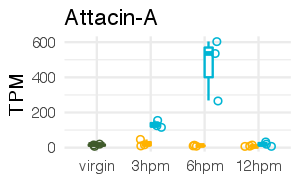

In [180]:
options(repr.plot.width = 2.5, repr.plot.height = 1.5)
ggplot(subset(intereseting.gene.TPM.table, gene_id == "FBgn0207711" & tissue == "Fem. RT"), aes(time, TPM, colour = condition)) +
    geom_boxplot(position = "dodge", outlier.size = 0, width = 0.3) + 
    geom_point(pch = 21, position = position_jitterdodge(), aes(colour = condition)) + 
#     facet_grid(~SwissProt_BlastX_Description, scales = "free_y", space = "free_x") + 
    labs(title = paste(unique(subset(intereseting.gene.TPM.table, gene_id == "FBgn0207711" & tissue == "Fem. RT")$SwissProt_BlastX_Description, sep = "")), size = 10) + 
    theme_minimal() +
    scale_colour_manual(values = c("#3f5a2a","#ffb200","#00b5d4")) +
    theme(legend.position = "none", axis.title.x = element_blank())


In [150]:
subset(intereseting.gene.TPM.table, gene_id == "FBgn0017815" & tissue == "Fem. RT")

,gene_id,replicate_id,TPM,sample,replicate,tissue,sex,condition,time,gene_name,SwissProt_BlastX_Description,function.
1,FBgn0017815,Female_C3_RT_3,6.321,Female_C3_RT,3,Fem. RT,female,conspecific,3hpm,Cec3,Cecropin-1/3,immunity
4,FBgn0017815,Female_H12_RT_2,16.020,Female_H12_RT,2,Fem. RT,female,heterospecific,12hpm,Cec3,Cecropin-1/3,immunity
5,FBgn0017815,Female_H3_RT_1,1.927,Female_H3_RT,1,Fem. RT,female,heterospecific,3hpm,Cec3,Cecropin-1/3,immunity
7,FBgn0017815,Female_C6_RT_1,8.909,Female_C6_RT,1,Fem. RT,female,conspecific,6hpm,Cec3,Cecropin-1/3,immunity
9,FBgn0017815,Female_C6_RT_2,2.525,Female_C6_RT,2,Fem. RT,female,conspecific,6hpm,Cec3,Cecropin-1/3,immunity
10,FBgn0017815,Female_C3_RT_2,0.000,Female_C3_RT,2,Fem. RT,female,conspecific,3hpm,Cec3,Cecropin-1/3,immunity
12,FBgn0017815,Female_C12_RT_3,0.003,Female_C12_RT,3,Fem. RT,female,conspecific,12hpm,Cec3,Cecropin-1/3,immunity
15,FBgn0017815,Female_H3_RT_3,31.171,Female_H3_RT,3,Fem. RT,female,heterospecific,3hpm,Cec3,Cecropin-1/3,immunity
16,FBgn0017815,Female_H3_RT_2,25.183,Female_H3_RT,2,Fem. RT,female,heterospecific,3hpm,Cec3,Cecropin-1/3,immunity
17,FBgn0017815,Female_C12_RT_2,0.749,Female_C12_RT,2,Fem. RT,female,conspecific,12hpm,Cec3,Cecropin-1/3,immunity


In [148]:
head(intereseting.gene.TPM.table)

gene_id,replicate_id,TPM,sample,replicate,tissue,sex,condition,time,gene_name,SwissProt_BlastX_Description,function.
FBgn0017815,Female_C3_RT_3,6.321,Female_C3_RT,3,Fem. RT,female,conspecific,3hpm,Cec3,Cecropin-1/3,immunity
FBgn0017815,Female_C6_OV_2,0.125,Female_C6_OV,2,ovaries,female,conspecific,6hpm,Cec3,Cecropin-1/3,immunity
FBgn0017815,Female_H6_OV_2,23.443,Female_H6_OV,2,ovaries,female,heterospecific,6hpm,Cec3,Cecropin-1/3,immunity
FBgn0017815,Female_H12_RT_2,16.020,Female_H12_RT,2,Fem. RT,female,heterospecific,12hpm,Cec3,Cecropin-1/3,immunity
FBgn0017815,Female_H3_RT_1,1.927,Female_H3_RT,1,Fem. RT,female,heterospecific,3hpm,Cec3,Cecropin-1/3,immunity
FBgn0017815,Female_C6_H_2,19.176,Female_C6_H,2,head,female,conspecific,6hpm,Cec3,Cecropin-1/3,immunity


In [126]:
head(vetted_DE)

FBgn_ID,function.
FBgn0017815,immunity
FBgn0207711,immunity
FBgn0207804,immunity
FBgn0209590,immunity
FBgn0203480,immunity
FBgn0210579,immunity


In [127]:
head(newSub)

Gene_ID,cluster,variable,value,condition,time,crossType
FBgn0013073,cluster_1,Female_V_RT,-1.0805325,virgin,virgin,conspecific
FBgn0017815,cluster_1,Female_V_RT,-2.5303306,virgin,virgin,conspecific
FBgn0197572,cluster_1,Female_V_RT,-0.2568816,virgin,virgin,conspecific
FBgn0197687,cluster_1,Female_V_RT,-0.7206436,virgin,virgin,conspecific
FBgn0198007,cluster_1,Female_V_RT,-0.8829489,virgin,virgin,conspecific
FBgn0199249,cluster_1,Female_V_RT,-0.4470842,virgin,virgin,conspecific


In [121]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8"))
options(repr.plot.width = 7, repr.plot.height = 5)
pdf("cluster_groupings.pdf", width = 7, height = 5)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.4,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y') +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
dev.off()

pdf 
  2

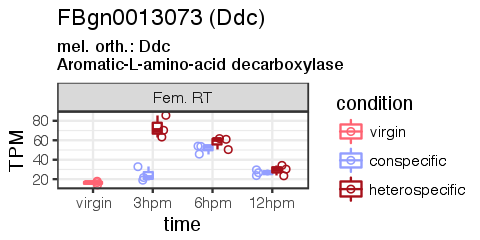

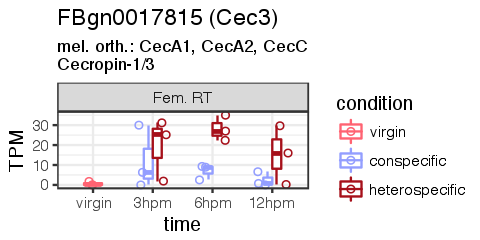

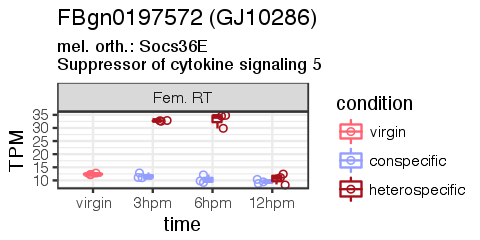

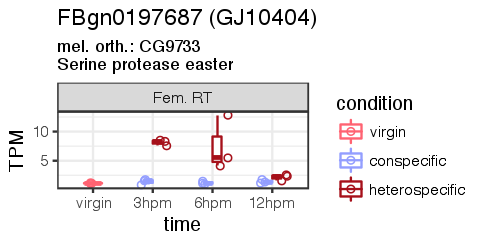

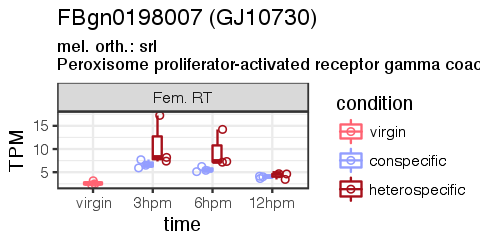

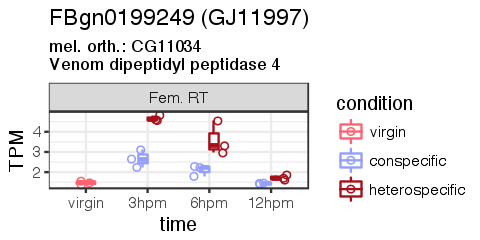

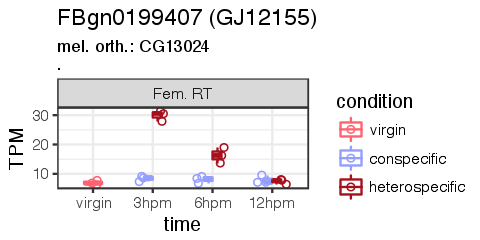

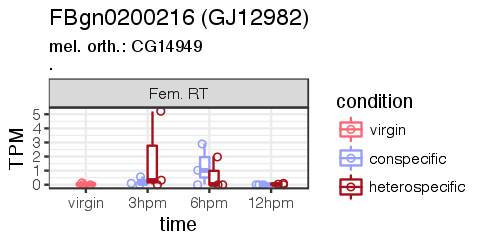

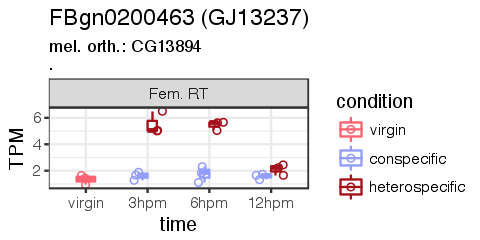

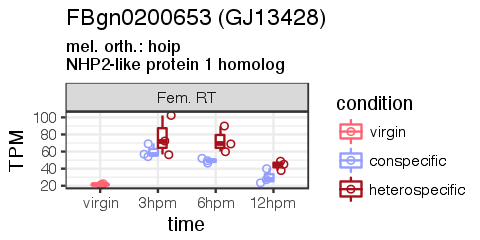

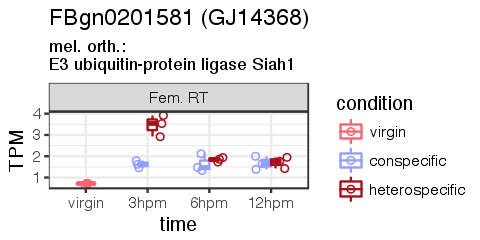

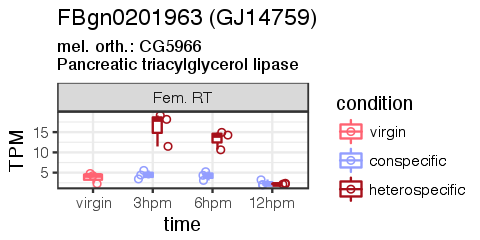

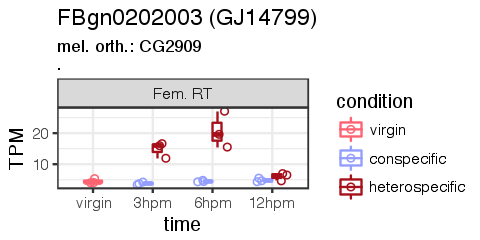

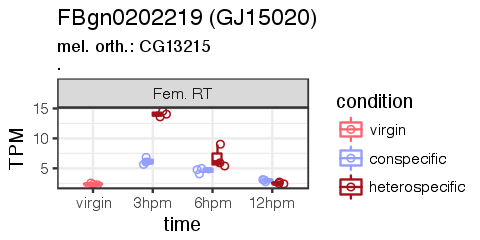

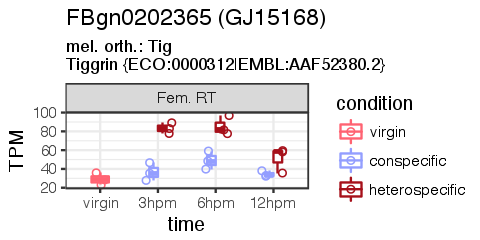

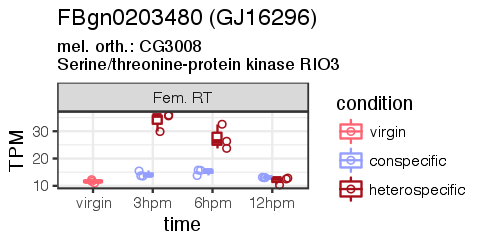

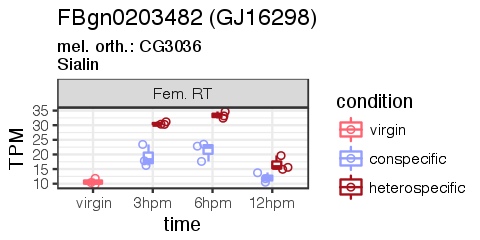

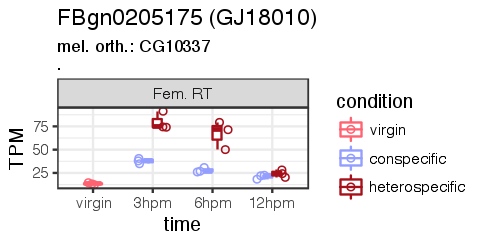

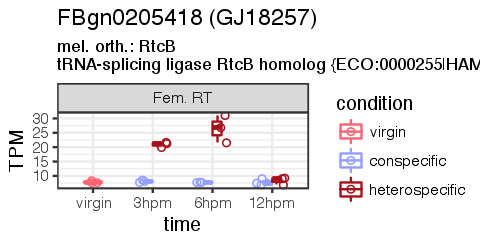

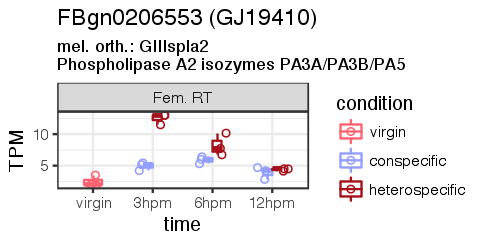

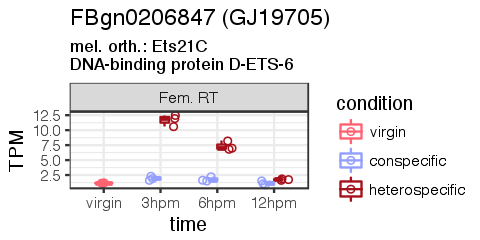

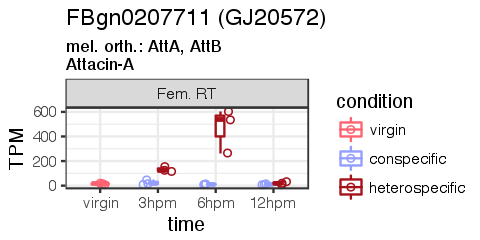

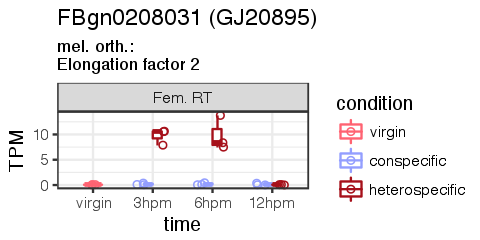

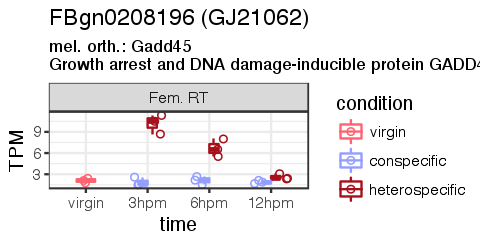

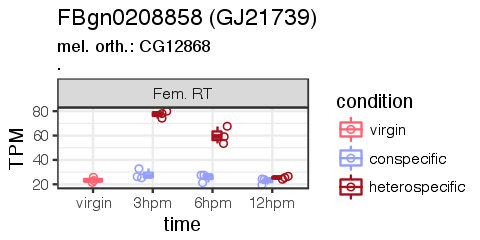

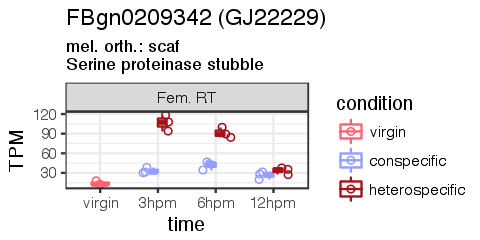

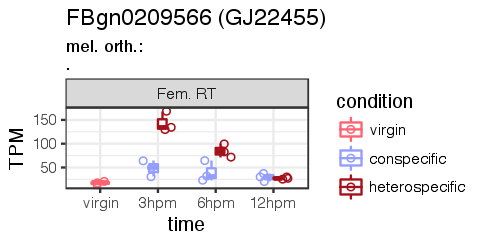

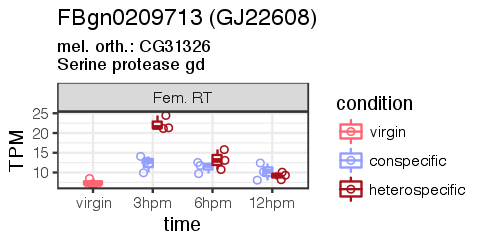

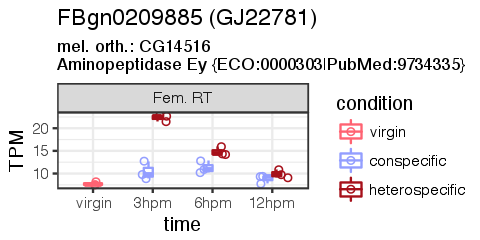

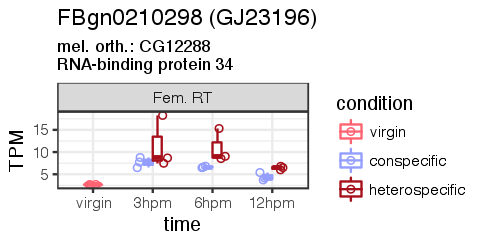

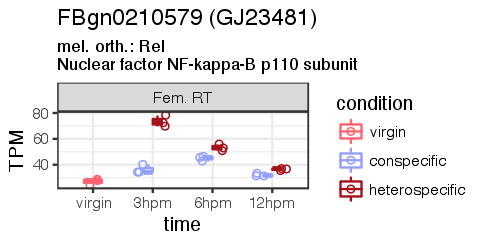

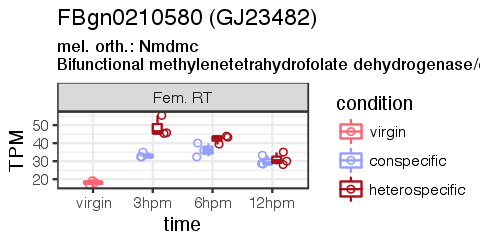

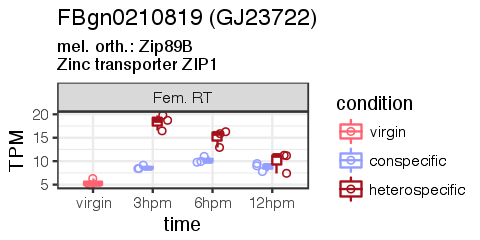

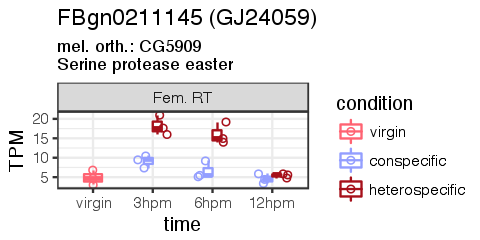

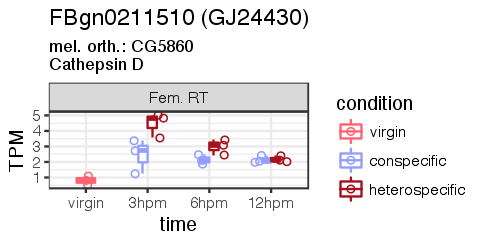

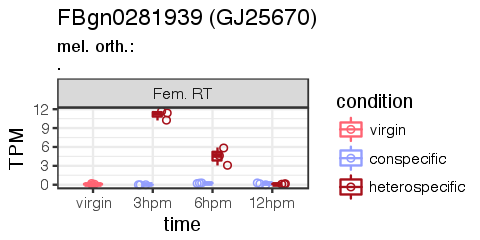

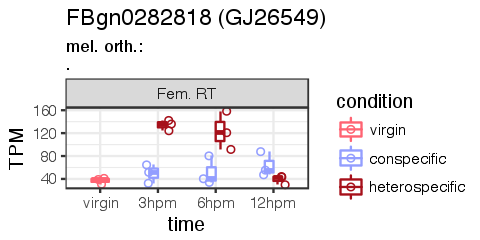

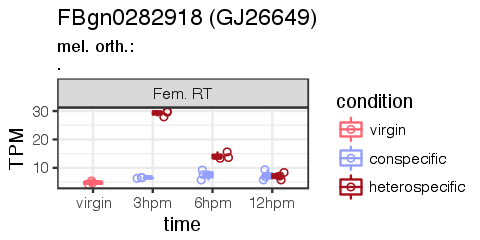

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]

[[26]]

[[27]]

[[28]]

[[29]]

[[30]]

[[31]]

[[32]]

[[33]]

[[34]]

[[35]]

[[36]]

[[37]]

[[38]]

[[39]]

[[40]]


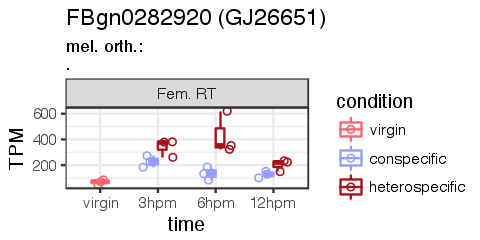

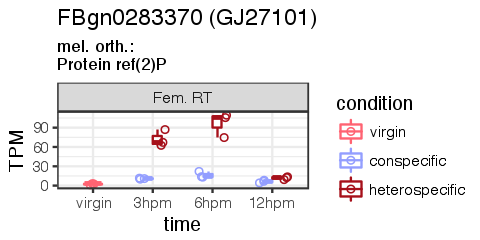

In [115]:
options(repr.plot.width = 4, repr.plot.height = 2)
lapply(unique(subset(newSub, cluster == "cluster_1")$Gene_ID), boxPlotPM2, object = subset(g.TPM.table, tissue == "Fem. RT"))

GO analysis on all clusters but cluster_12 have no significant enrichment. We can output the cluster_12 results below:

In [99]:
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C12.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C12.enrich_result_table$category, get_GO_term_descr))
C12.enrich_result_table$go_term = descr
C12.enrich_result_table$factor = go_enrich_factor



options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(subset(C12.enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  +
    xlab(NULL) + 
    geom_text_repel(data = subset(C12.enrich_result_table, over_represented_FDR < 0.05), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4"))

ERROR: Error in unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]): object 'newSub' not found


Let's look at GO enrichment across all upregulated genes:

In [ ]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor

And can plot them as before:

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(subset(enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  +
    xlab(NULL) + 
    geom_text_repel(data = subset(enrich_result_table, over_represented_FDR < 0.05), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

We can output a PDF of gene plots for all upregulated genes:

In [ ]:
head(g.TPM.table)

In [ ]:
boxPlotPM

In [ ]:
head(g.TPM.table)

In [100]:
boxPlotPM2 <- function (object, gene) 
{
    if (grepl("FBgn", gene)) {
            geneName <- subset(annot.sum, FBgn_ID == 
                gene)$gene_name
        }
        else {
            geneName <- subset(annot.sum, gene_name == 
                gene)$FBgn_ID
        }
        swisprotName <- subset(annot.sum, FBgn_ID == gene | gene_name == gene)$SwissProt_BlastX_Description
        melOrth <- subset(melOrthsAll, FBgn_ID == gene)$mel_GeneSymbol
        p <- ggplot(subset(object, gene_id == gene), aes(time, TPM, colour = condition)) + 
            geom_boxplot(position = "dodge", outlier.size = 0, 
                width = 0.3) + geom_point(pch = 21, position = position_jitterdodge(), 
            aes(colour = condition)) + facet_grid(~tissue, scales = "free_x", 
            space = "free_x") + labs(title = paste(gene, " (", 
            geneName, ")", sep = ""), subtitle = paste("mel. orth.: ", 
            melOrth, "\n", swisprotName, sep = "")) + theme_bw() +
            scale_colour_manual(values = c("#3f5a2a","#ffb200","#00b5d4"))
    
    return(p)
}

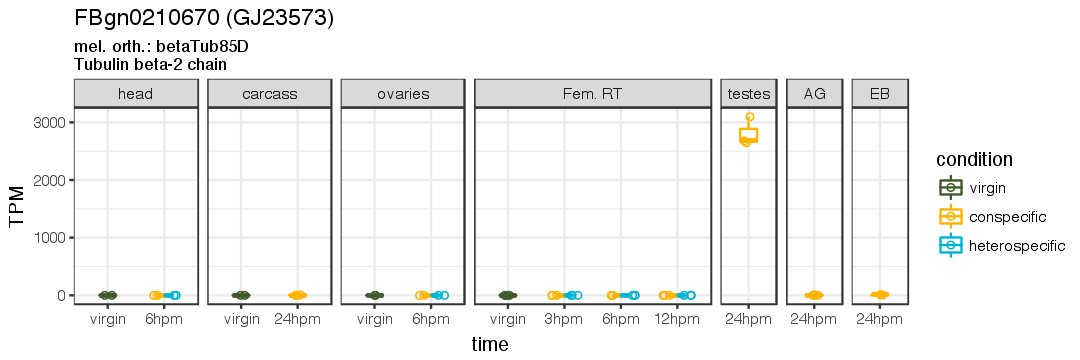

In [101]:
options(repr.plot.width = 9, repr.plot.height = 3)
boxPlotPM2(object = g.TPM.table, "FBgn0210670")

In [ ]:
upregulated_genes.Plots = suppressMessages(lapply(unique(newSub$Gene_ID), boxPlotPM2, object = subset(g.TPM.table, tissue == "Fem. RT")))
ggsave("Snakemake_output_files/Plots/g.upregulated_genes.pdf", marrangeGrob(grobs = upregulated_genes.Plots, nrow = 3, ncol = 2))

upregulated_genes.Plots = suppressMessages(lapply(unique(newSub$Gene_ID), boxPlotPM2, object = g.TPM.table))
ggsave("Snakemake_output_files/Plots/g.upregulated_genes_all_tissues.pdf", marrangeGrob(grobs = upregulated_genes.Plots, nrow = 3, ncol = 1))

## Differential Expression (Trinity analysis)

#### Trinity-based Bowtie2:

First we'll subset the matrix to include virgin female tissue samples.

In [ ]:
bowtie2_trinity_geneCounts.tissues = subset(bowtie2_trinity_geneCounts, select=grepl("Female_V", colnames(bowtie2_trinity_geneCounts)))

Now we can filter out low expression genes with a minimum 5 cpm cutoff (NOTE: Setting the threshold column number to 3 dramatically changes the number of tissue biased genes in this section).

In [ ]:
cpmMatrix.bowtie2_trinity_geneCounts.tissues <- cpm(bowtie2_trinity_geneCounts.tissues)
v.thresh <- cpmMatrix.bowtie2_trinity_geneCounts.tissues > 10
## look at number of columns with above requirements
table(rowSums(v.thresh))

v.keep <- rowSums(v.thresh) >= 2
countsMatrix.bowtie2_trinity_geneCounts.tissues.filt <- bowtie2_trinity_geneCounts.tissues[v.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.bowtie2_trinity_geneCounts.tissues.filt)

We'll also subset the samplesData object to only include the virgin tissue and male samples:

In [ ]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
head(sampleInfo.v, n =2)

We can now define groups for differential expression:

In [ ]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate

Now we'll create the DGE object and fit the general linear model:

In [ ]:
dgeList.v <- DGEList(counts = countsMatrix.bowtie2_trinity_geneCounts.tissues.filt, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can add annotation information to the fit object, and it in the genes slot:

In [ ]:
# # Extract annotation for genes in the fit object
# ann.v = subset(tTrinotate.sub.some, gene_id.y %in% rownames(dgeList.v_fit))
# # convert factors to characters
# ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# # align the fit object's rownames with gene ID's
# ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$gene_id.y),]
# # convert factors to characters, again
# ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# # Rename "FBgn_ID" as "GeneID"
# colnames(ann.v) = c ("GeneID", "MSTRG_ID", "gene_name", "sprot_Top_BLASTX_hit_description")
# # Check that the fit rownames match the annotation file's gene ID's
# table(ann.v$GeneID==rownames(dgeList.v_fit))
# # Add the annotations to the fit object in the "genes" slot
# dgeList.v_fit$genes = ann.v

A quick look at the dispersion stats:

In [ ]:
summary(dgeList.v$tagwise.dispersion)

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea voom object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [ ]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.v$Replicate)

Replicates are grouping correctly. Another way to look at grouping is a heatmap of sample correlations:

In [ ]:
## Plot sample correlation
data = log2(countsMatrix.bowtie2_trinity_geneCounts.tissues.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 4, repr.plot.height =4)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [ ]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

##### Reprotductive tract

In [ ]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001)$GeneID
paste(length(repTract.list), " genes show RT-biased expression", sep = "")

###### Ovaries

In [ ]:
lrt.v.ovaries <- glmLRT(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.ovaries.tTags <- topTags(lrt.v.ovaries, n = NULL)
lrt.v.ovaries.tTags.table <- lrt.v.ovaries.tTags$table
ovaries.list<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001)$GeneID
paste(length(ovaries.list), " show ovary-biased expression", sep = "")

###### Head:

In [ ]:
lrt.v.head <- glmLRT(dgeList.v_fit, contrast = cont.v.head)
lrt.v.head.tTags <- topTags(lrt.v.head, n = NULL)
lrt.v.head.tTags.table <- lrt.v.head.tTags$table
head.list<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001)$GeneID
paste(length(head.list), " show head-biased expression", sep = "")

We can generate a tissue-biased factor table to annotate a simple heatmap of the tissue-biased genes (this can also be used for GO analysis later):

In [ ]:
RT_factors = as.data.frame(repTract.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = repTract.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(head.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = head.list
H_factors = subset(H_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, OV_factors, H_factors)
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [ ]:
tissueBiased.meanTPM = subset(bowtie2_trinity_TPM, rownames(bowtie2_trinity_TPM) %in% rownames(virgin.factor.labeling))
tissueBiased.meanTPM.v = subset(tissueBiased.meanTPM, select=grepl("Female_V", colnames(tissueBiased.meanTPM)))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the heatmap3 package):

In [ ]:
data = tissueBiased.meanTPM.v
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(virgin.factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#e1526d", "#b85516", "#647700")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

Now we plot it:

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
heatmap3(heatmap_data, 
         col=myheatcol, 
         cexCol = 0.5, 
         labRow = "", 
         legendfun=function() showLegend(legend=c("OV-biased", "H-biased", "RT-biased"), col=c("#e1526d", "#b85516", "#647700"), cex = 0.5), 
        cex.main=0.4, 
             RowSideColors = geneFactorAnnotations)

#### Gene Ontology

Need gene length information and GO annotation files for GOseq:

In [ ]:
trinityT_gene_lengths <- as.data.frame(trinity_gene_lengths[order(trinity_gene_lengths$gene_id),])
rownames(trinityT_gene_lengths) <- trinityT_gene_lengths$gene_id
trinityT_gene_lengths[,1] <- NULL

Now the GO info:

In [ ]:
GO_info_listed = apply(trinity_GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(trinity_GO_info)
features_with_GO = rownames(trinity_GO_info)
lengths_features_with_GO = as.integer(trinityT_gene_lengths[features_with_GO,])
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

In [ ]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [ ]:
GO_enriched_list = list()

for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling)[virgin.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

The results are saved in GO_enrichment_data. We can take a look at the output format. Here's an example of how to plot it (for the RT-biased category):

In [ ]:
### RT plot
options(repr.plot.width = 9, repr.plot.height = 5)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased" & !is.na(ontology)), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, factor == "RT-biased" & over_represented_FDR < 0.05 & numDEInCat > 50), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))
#dev.off()

## Reproductive tract post-mating contrasts:

Create RT-specific count matrix 

In [ ]:
t.bt2.countsMatrix.pm = subset(bowtie2_trinity_geneCounts, select=grepl("RT", colnames(bowtie2_trinity_geneCounts)))
# countsMatrix.pm = subset(countsMatrix.pm, select=RT_GoodReps)
head(t.bt2.countsMatrix.pm)

Now let's filter low expression genes within a minimum cpm of 2:

In [ ]:
t.bt2.cpmMatrix.pm <- cpm(t.bt2.countsMatrix.pm)
t.bt2.pm.thresh <- t.bt2.cpmMatrix.pm > 10
## look at number of columns with above requirements
table(rowSums(t.bt2.pm.thresh))

t.bt2.pm.keep <- rowSums(t.bt2.pm.thresh) >= 3
t.bt2.countsMatrix.pm.filt <- t.bt2.countsMatrix.pm[t.bt2.pm.keep,]
## Check how many genes remain in the matrix.
dim(t.bt2.countsMatrix.pm.filt)

We already subset the samplesInfo object to only include the RT samples, but just as a reminder:

In [ ]:
# sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# # remove rogue replicates:
# sampleInfo.pm = subset(sampleInfo.pm, Replicate != "H3_RT_1" & Replicate != "H6_RT_1")
# head(sampleInfo.pm)

#### 1. Comparing postmating samples to virgin:

We already defined the relevant groups for this comparison but show it again as a reminder:

In [ ]:
# ## Will need to relevel the Status grouping to make virgin control
# sampleInfo.pm$Status <- relevel(sampleInfo.pm$Status, ref = "virgin")
# groups.pm.1 <- factor(sampleInfo.pm$Status)
# design.pm.1 <- model.matrix(~groups.pm.1)
# colnames(design.pm.1) <- levels(groups.pm.1)
# rownames(design.pm.1) <- sampleInfo.pm$Replicate
# head(design.pm.1)

Create edgeR DE object and run glmFit

In [ ]:
dgeList.pm.1 <- DGEList(counts = t.bt2.countsMatrix.pm.filt, group = groups.pm.1)
dgeList.pm.1 <- calcNormFactors(dgeList.pm.1)
dgeList.pm.1 <- estimateCommonDisp(dgeList.pm.1)
dgeList.pm.1 <- estimateTagwiseDisp(dgeList.pm.1)
dgeList.pm.1_fit <- glmFit(dgeList.pm.1, design.pm.1)

Let's add the annotation information to this fit object:

In [ ]:
# Extract annotation for genes in the fit object
ann.pm.1 = subset(tTrinotate.sub.some, gene_id.y %in% rownames(dgeList.pm.1_fit))
# convert factors to characters
ann.pm.1 = data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pm.1 = ann.pm.1[match(rownames(dgeList.pm.1_fit), ann.pm.1$gene_id.y),]
# convert factors to characters, again
ann.pm.1 <- data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pm.1) = c ("GeneID", "MSTRG_ID", "gene_name", "sprot_Top_BLASTX_hit_description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pm.1$GeneID==rownames(dgeList.pm.1_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pm.1_fit$genes = ann.pm.1

Also, check the tagwise dispersion summary:

In [ ]:
summary(dgeList.pm.1$tagwise.dispersion)

Looks decent. Now let's look at the biological coefficient of variation to examine variability within each sample. It would also be useful to generate a voom object as an aside to compare to the edgeR analyses (from this object we can look at the mean-variance trend). Also, let's generate a QQ-plot.

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pm.1)
# mean-variance trend
pm.1.voom = voom(dgeList.pm.1, design.pm.1, plot=TRUE)
# QQ-plot
g.pm.1 <- gof(dgeList.pm.1_fit)
z.pm.1 <- zscoreGamma(g.pm.1$gof.statistics,shape=g.pm.1$df/2,scale=2)
qqnorm(z.pm.1); qqline(z.pm.1, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pm.1.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(pm.1.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [ ]:
## colour samples by tissue-type
col.Status <- c("#8d75ca","#78a450","#c16786")[sampleInfo.pm$Status]
chr.time <- c(21:24)[sampleInfo.pm$time]

options(repr.plot.width = 8, repr.plot.height = 5)
plotMDS(dgeList.pm.1, col=col.Status, pch= chr.time, cex = 2)
legend("topright",legend=levels(sampleInfo.pm$Status), fill = c("#8d75ca","#78a450","#c16786"), cex = 1)
legend("bottomright",legend=levels(sampleInfo.pm$time), pch = c(21:24), cex = 1)
# Add a title
title("reproductive tract samples")

Can also look at int interactively with Glimma:

In [ ]:
glMDSPlot(dgeList.pm.1, groups = sampleInfo.pm, labels = sampleInfo.pm$Replicate)

Replicates seem to largely group together in the first component, but two samples (H3_RT_1 and H6_RT_1) deviate from their sisters a bit. We'll consider removing those from the analysis later. For now, let's look at samples correlation:

In [ ]:
## Plot sample correlation
data = log2(t.bt2.countsMatrix.pm.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

The correlations are mostly good. The three samples that aren't grouping where they should are:
C6_RT_3
H3_RT_1
H6_RT_1
Now we can identify differentially expressed genes between postmating and virgin RT samples. First we'll compare conspecific to vrigin (coef=2), and use the log-fold cutoff of 1 (2-fold).

In [ ]:
lrt_con.v.vir <- glmTreat(dgeList.pm.1_fit, coef =2, lfc =1)

#extract gene list of DE genes
DE.genes_con.v.virg <- subset(topTags(lrt_con.v.vir, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_con.v.virg

... Now compare heterospecific to virgin:

In [ ]:
lrt_het.v.vir <- glmTreat(dgeList.pm.1_fit, coef =3, lfc =1)

#extract gene list of DE genes
DE.genes_het.v.virg <- subset(topTags(lrt_het.v.vir, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_het.v.virg

We can make a venn diagram of the above gene lists.

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 1)
RT_DE_vs.virgin_candidates <- list(Conspecific = DE.genes_con.v.virg, Heterospecific = DE.genes_het.v.virg)
RT_DE_vs.virgin_combs <- unlist(lapply(1:length(RT_DE_vs.virgin_candidates), function(j) combn(names(RT_DE_vs.virgin_candidates), j, simplify = FALSE)), recursive = FALSE)
names(RT_DE_vs.virgin_combs) <- sapply(RT_DE_vs.virgin_combs, function(i) paste0(i, collapse = ","))
RT_DE_vs.virgin_elements <- lapply(RT_DE_vs.virgin_combs, function(i) Setdiff(RT_DE_vs.virgin_candidates[i], RT_DE_vs.virgin_candidates[setdiff(names(RT_DE_vs.virgin_candidates), i)]))
RT_DE_vs.virgin_Vdiag<-venn.diagram(RT_DE_vs.virgin_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 1, resolution = 1000, main = "Postmating DE genes")
grid.arrange(gTree(children=RT_DE_vs.virgin_Vdiag))

We can output PDFs of individual gene plots:

In [ ]:
DE.genes_het.v.virg.Plots = suppressMessages(lapply(DE.genes_het.v.virg, boxPlotPM, object = subset(t.TPM.table, tissue == "Fem. RT"), trinity = T))
ggsave("Snakemake_output_files/Plots/t.DE.genes_het.v.virg.pdf", marrangeGrob(grobs = DE.genes_het.v.virg.Plots, nrow = 3, ncol = 2))

DE.genes_con.v.virg.Plots = suppressMessages(lapply(DE.genes_con.v.virg, boxPlotPM, object = subset(t.TPM.table, tissue == "Fem. RT"), trinity = T))
ggsave("Snakemake_output_files/Plots/t.DE.genes_con.v.virg.pdf", marrangeGrob(grobs = DE.genes_con.v.virg.Plots, nrow = 3, ncol = 2))

Some notable genes in the above lists:


#### 2. Comparing heterospecific to conspecific RT samples

We can use the above design to test for overall DE between conspecific and heterospecific postmating samples:

In [ ]:
lrt_con.v.het <- glmTreat(dgeList.pm.1_fit, contrast = c(0,-1,1), lfc =1)

#extract gene list of DE genes
DE.genes_con.v.het <- subset(topTags(lrt_con.v.het, n = NULL)$table, FDR < 0.05)$GeneID
DE.genes_con.v.het

Here's a Volcano plot of those results:

In [ ]:
dt.con.v.het = decideTestsDGE(lrt_con.v.het)
glXYPlot(x=lrt_con.v.het$table$logFC, y=-log10(lrt_con.v.het$table$PValue), xlab="logFC", ylab="logodds", status=dt.con.v.het, groups=sampleInfo.pm$SampleName, side.main="gene_name", anno = ann.pm.1, counts = dgeList.pm.1)

Let's make barplots of those genes:

In [ ]:
DE.genes_con.v.het.Plots = suppressMessages(lapply(DE.genes_con.v.het, boxPlotPM, object = subset(t.TPM.table, tissue == "Fem. RT"), trinity = T))
ggsave("Snakemake_output_files/Plots/t.DE.genes_con.v.het.pdf", marrangeGrob(grobs = DE.genes_con.v.het.Plots, nrow = 3, ncol = 2))

Out of the 6 gene that are differentially expressed between all con- and heterospecific postmating time points (Defensin, Attacin, elongation factor 2, Larval cuticle protein 5, one unknown), two are clearly antimicropial peptides and are upregulated in the heterospecific samples. The gene that is upregulated in the conspecific condition (ninaE) is a rhodospin gene, and looks like one of the conspcific 6hpm replicates is responsible for the difference, thus likely a false-positive.

Using this approach, which looks for significant differences by averaging across all three time points, only six genes show up as significant between conspecific and heterospecific samples. To detect more DE genes, we'll need to compare samples within each postmating time point.

#### 3. Comparing each postmating time point to the virgin RT sample

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [ ]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$time, sep="."))
sampleInfo.pm.3 <- cbind(sampleInfo.pm, Group=Status.time)
sampleInfo.pm.3$Group <- relevel(sampleInfo.pm.3$Group, ref = "virgin.0hpm")

groups.pm.3 <- factor(sampleInfo.pm.3$Group)
design.pm.3 <- model.matrix(~groups.pm.3)
colnames(design.pm.3) <- levels(groups.pm.3)
rownames(design.pm.3) <- sampleInfo.pm.3$Replicate

Create edgeR DE object and run glmFit

In [ ]:
dgeList.pm.3 <- DGEList(counts = t.bt2.countsMatrix.pm.filt, group = groups.pm.3)
dgeList.pm.3 <- calcNormFactors(dgeList.pm.3)
dgeList.pm.3 <- estimateCommonDisp(dgeList.pm.3)
dgeList.pm.3 <- estimateTagwiseDisp(dgeList.pm.3)
dgeList.pm.3_fit <- glmFit(dgeList.pm.3, design.pm.3)

Let's add the annotation information to this fit object:

In [ ]:
# Extract annotation for genes in the fit object
ann.pm.3 = subset(tTrinotate.sub.some, gene_id.y %in% rownames(dgeList.pm.3_fit))
# convert factors to characters
ann.pm.3 = data.frame(lapply(ann.pm.3, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pm.3 = ann.pm.3[match(rownames(dgeList.pm.3_fit), ann.pm.3$gene_id.y),]
# convert factors to characters, again
ann.pm.3 <- data.frame(lapply(ann.pm.3, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pm.3) = c ("GeneID", "MSTRG_ID", "gene_name", "sprot_Top_BLASTX_hit_description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pm.3$GeneID==rownames(dgeList.pm.3_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pm.3_fit$genes = ann.pm.3

Also, check the tagwise dispersion summary:

In [ ]:
summary(dgeList.pm.3$tagwise.dispersion)

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pm.3)
# mean-variance trend
pm.3.voom = voom(dgeList.pm.3, design.pm.3, plot=TRUE)
# QQ-plot
g.pm.3 <- gof(dgeList.pm.3_fit)
z.pm.3 <- zscoreGamma(g.pm.3$gof.statistics,shape=g.pm.3$df/2,scale=2)
qqnorm(z.pm.3); qqline(z.pm.3, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pm.3.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(pm.3.voom$E),col="blue")

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference:

In [ ]:
glmT_C3.v.vir <- glmTreat(dgeList.pm.3_fit, coef =3, lfc =1)
glmT_C6.v.vir <- glmTreat(dgeList.pm.3_fit, coef =4, lfc =1)
glmT_C12.v.vir <- glmTreat(dgeList.pm.3_fit, coef =2, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pm.3_fit, coef =6, lfc =1)
glmT_H6.v.vir <- glmTreat(dgeList.pm.3_fit, coef =7, lfc =1)
glmT_H12.v.vir <- glmTreat(dgeList.pm.3_fit, coef =5, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [ ]:
DE.genes_C3.v.vir_up <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C6.v.vir_up <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C12.v.vir_up <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H3.v.vir_up <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H6.v.vir_up <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H12.v.vir_up <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID

... and downregulated ones...

In [ ]:
DE.genes_C3.v.vir_down <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C6.v.vir_down <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C12.v.vir_down <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H3.v.vir_down <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H6.v.vir_down <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H12.v.vir_down <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID

What we can do now is compare and contrasts these individual lists, capture the overlap between them, and plot Venn diagrams. First, let's aggregate by cross type:

In [ ]:
RT_UP_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_up, Heterospecific = DE.genes_H3.v.vir_up)
RT_UP_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_up, Heterospecific = DE.genes_H6.v.vir_up)
RT_UP_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_up, Heterospecific = DE.genes_H12.v.vir_up)
RT_Down_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_down, Heterospecific = DE.genes_H3.v.vir_down)
RT_Down_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_down, Heterospecific = DE.genes_H6.v.vir_down)
RT_Down_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_down, Heterospecific = DE.genes_H12.v.vir_down)

Rearrange those into lists of lists, and partition by postmating time-point

In [ ]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

Assign names to each combination (i.e., con and het):

In [ ]:
names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

Now generate a list of each element:

In [ ]:
RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

Now we generate the Venn diagram objects and plot them:

In [ ]:
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 9, repr.plot.height = 3)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag), gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag), ncol = 6, top = "Upregulated                                                                       Downregulated")

Before we can look at Glimma volcano plots, we need to run the decideTestsDGE for each glmTreat output:

In [ ]:
dt_C3.v.vir = decideTestsDGE(glmT_C3.v.vir)
dt_C6.v.vir = decideTestsDGE(glmT_C6.v.vir)
dt_C12.v.vir = decideTestsDGE(glmT_C12.v.vir)
dt_H3.v.vir = decideTestsDGE(glmT_H3.v.vir)
dt_H6.v.vir = decideTestsDGE(glmT_H6.v.vir)
dt_H12.v.vir = decideTestsDGE(glmT_H12.v.vir)

Here's one example of a volcano plot between heterospecific 6hpm samples and virgins:

In [ ]:
glXYPlot(x=glmT_C6.v.vir$table$logFC, y=-log10(glmT_C6.v.vir$table$PValue), xlab="logFC", ylab="logodds", status=dt_C6.v.vir, groups=sampleInfo.pm$SampleName, side.main="gene_name", anno = ann.pm.3, counts = dgeList.pm.3)

#### Analysis of all upregulated genes in all PM RT condition:

First we'll look at thos genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [ ]:
RT_upregulated_genes = unique(unlist(c(RT_UP_3hrs_elements, RT_UP_6hrs_elements, RT_UP_12hrs_elements)))
message(paste("There are ", length(RT_upregulated_genes), " upregulated genes", sep =""))
RT_upregulated_genes_matrix = subset(t.meanTPMmatrix, rownames(t.meanTPMmatrix) %in% RT_upregulated_genes)

RT_upregulated_genes_matrix = RT_upregulated_genes_matrix[ , grepl("RT", names(RT_upregulated_genes_matrix))]
RT_upregulated_genes_matrix_con = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_upregulated_genes_matrix_het = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_upregulated_genes_matrix)

Creudly, it looks like 11-13 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [ ]:
data = RT_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=12)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [ ]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

In [ ]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [ ]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [ ]:
conSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

In [ ]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8", "cluster_9", "cluster_10", "cluster_11", "cluster_12"))
options(repr.plot.width = 7, repr.plot.height = 5)
# pdf("cluster_groupings.pdf", width = 7, height = 5)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#b067a3",
              alpha = 0.4,
              size = 1) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#9c954d",
              alpha = 0.5,
              size = 1) +
    theme_bw() + 
    facet_wrap('cluster',scales='free_y') +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

GO analysis on all clusters but cluster_12 have no significant enrichment. We can output the cluster_12 results below:

In [ ]:
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_4"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C12.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C12.enrich_result_table$category, get_GO_term_descr))
C12.enrich_result_table$go_term = descr
C12.enrich_result_table$factor = go_enrich_factor



options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(subset(C12.enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  +
    xlab(NULL) + 
    geom_text_repel(data = subset(C12.enrich_result_table, over_represented_FDR < 0.05 & numDEInCat > 6), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

Let's look at GO enrichment across all upregulated genes:

In [ ]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor

And can plot them as before:

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(subset(enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  +
    xlab(NULL) + 
    geom_text_repel(data = subset(enrich_result_table, over_represented_FDR < 0.05 & numDEInCat > 5), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

We can output a PDF of gene plots for all upregulated genes:

In [ ]:
upregulated_genes.Plots = suppressMessages(lapply(unique(newSub$Gene_ID), boxPlotPM, object = subset(t.TPM.table, tissue == "Fem. RT"), trinity = T))
ggsave("Snakemake_output_files/Plots/t.upregulated_genes.pdf", marrangeGrob(grobs = upregulated_genes.Plots, nrow = 3, ncol = 2))

upregulated_genes.Plots = suppressMessages(lapply(unique(newSub$Gene_ID), boxPlotPM, object = t.TPM.table, trinity = T))
ggsave("Snakemake_output_files/Plots/t.upregulated_genes_all_tissues.pdf", marrangeGrob(grobs = upregulated_genes.Plots, nrow = 3, ncol = 1))

In [ ]:
boxPlotPM(g.TPM.table, "GJ17456")